In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from utils import SHIPS_ML_model_funcs
from utils import SHIPS_plotting
import matplotlib.colors
import os

##### Experiment info for all models

In [11]:
fpath_load = 'DATA/ML_model_results/TESTING/all_models_ROS_and_SMOTE/'
train_yr_start = 2005
train_yr_end = 2018
test_yr_end = 2021
mask_TYPE = 'SIMPLE'
is_stand = True
if is_stand:
    stand_str = 'STANDARDIZED'
else:
    stand_str = 'no_STANDARD'
RI_thresh = 30
wts_str = 'default'
score = 'f1_weighted'

##### Load experiments

In [12]:
path_suff = 'TEST_SHIPS_vs_no_RI_{yr_start}-{yr_end}_{mask_TYPE}_MASK_{stand_str}_RI_thresh_{RI_thresh}'\
'_{scoring}.csv'.format(yr_start=train_yr_start,yr_end=test_yr_end,mask_TYPE=mask_TYPE,
                           stand_str=stand_str,RI_thresh=RI_thresh,scoring=score)
cm_res = pd.read_csv(fpath_load+'Conf_Matrix'+path_suff)
cm_res['Model'] = cm_res['Model'].replace({'Random Forest (random oversample)':'ROS',
                                         'Random Forest (SMOTE)':'SMOTE','Random Forest (class wt)':'RFwt'})

#### Part 1. Plots from confusion matrix
We can make several plots with our confusion matrix results:
* Performance diagram for training data
* Box plots of PoD, FAR, CSI; Hits, and Misses

##### Performance diagram.  
This plot summarizes our results for the training data. For our bootstrapped training data, we show the median false alarm ratio / probability of detection values as well as a 95% confidence interval (error bars). It also shows us our results in the context of frequency bias (diagonal lines; are we over/underforecasting our event?) and critical success index (contours), which is another metric that summarizes hits, misses, and false alarms all together.  

In [13]:
fig_dir_save = 'Figures/TESTING/'
if not os.path.exists(fig_dir_save):
    os.makedirs(fig_dir_save)

/home/mmcgraw/miniconda3/envs/SHIPS/lib/python3.9/site-packages/IPython/core/interactiveshell.py:2947: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


Unnamed: 0       FAR  N_predicted  False Alarms  Category  \
Model                                                                      
Logistic Reg.           1  0.595745           94            56       1.0   
RFwt                    1  0.426230           61            26       1.0   
ROS                     1  0.370370           54            20       1.0   
SMOTE                   1  0.333333           51            17       1.0   

                    POD  N_actual  Misses        SR  Correct Negs  ...  Hits  \
Model                                                              ...         
Logistic Reg.  0.666667        57      19  0.404255            57  ...    38   
RFwt           0.614035        57      22  0.573770            87  ...    35   
ROS            0.596491        57      23  0.629630            93  ...    34   
SMOTE          0.596491        57      23  0.666667            96  ...    34   

                   PFOD      BIAS  Max Depth  Max Features  N Estimators  \
Model                                                                      
Logistic Reg.  0.495575  1.649123        NaN           NaN           NaN   
RFwt           0.230088  1.070175       11.0           5.0         250.0   
ROS            0.176991  0.947368       11.0           4.0         250.0   
SMOTE          0.150442  0.894737       11.0           5.0         250.0   

               Min Samples Leaf  Max Iter  Fold     C  
Model                                                  
Logistic Reg.               NaN     100.0     0  0.01  
RFwt                       10.0       NaN     0   NaN  
ROS                        10.0       NaN     0   NaN  
SMOTE                      10.0       NaN     0   NaN  

[4 rows x 21 columns]

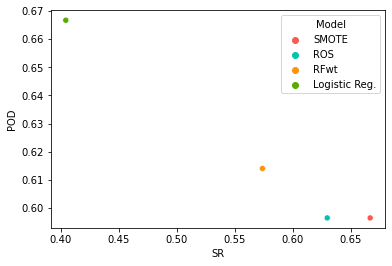

In [14]:
foo = cm_res.set_index(['Category Names','BASIN','Model']).xs(('RI','WEST_PACIFIC')).reset_index()
sns.scatterplot(data=foo,x='SR',y='POD',hue='Model')
foo.groupby('Model').median()

/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_plotting.py:214: UserWarning: The following kwargs were not used by contour: 'axes'
  ax.contourf(success_ratio_matrix, pod_matrix, csi_matrix,
/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_plotting.py:229: UserWarning: The following kwargs were not used by contour: 'axes'
  bias_contour_object = ax.contour(


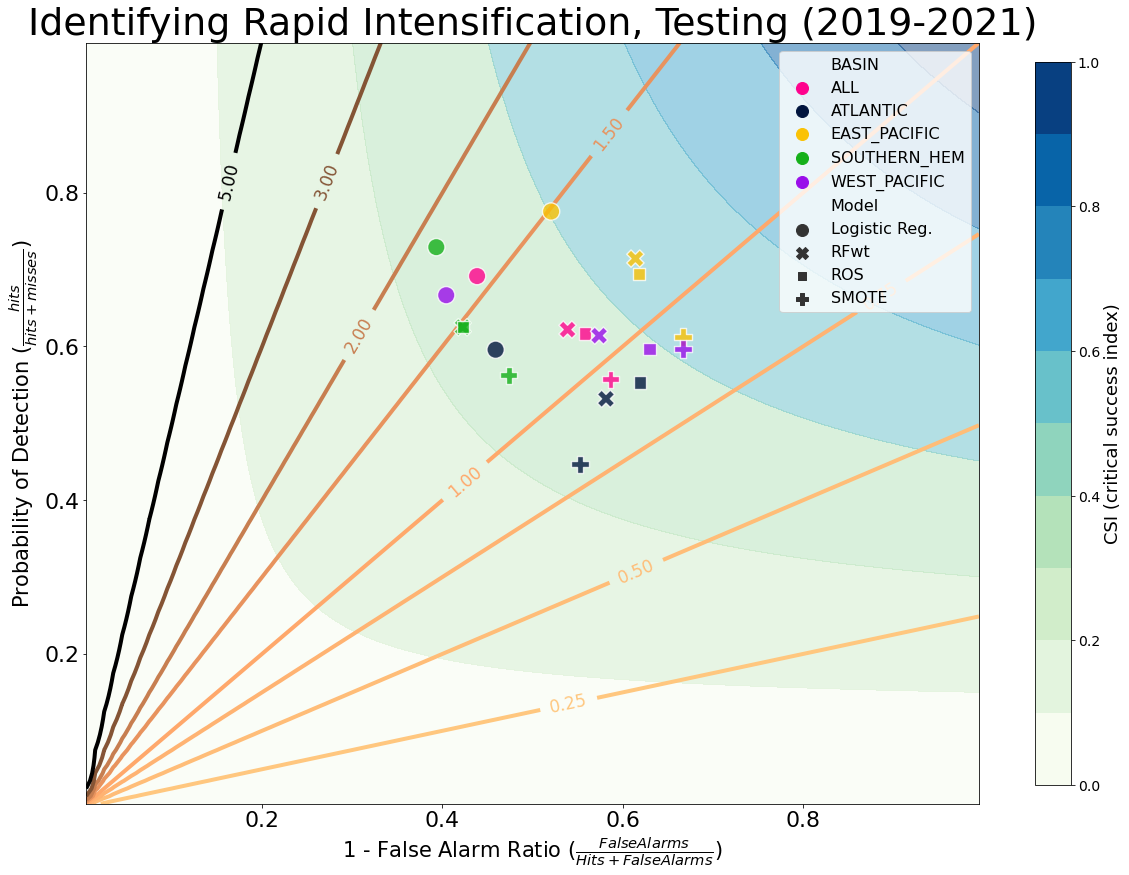

In [15]:
fig1,ax1 = plt.subplots(1,1,figsize=(20,14))
SHIPS_plotting.make_performance_diagram_background(ax1)
# Save empty PD in case we ever need it for a presentation
# Now, add results to PD
SHIPS_plotting.add_model_results(ax1,cm_res)
ax1.legend(fontsize=16,markerscale=2)
ax1.set_title('Identifying Rapid Intensification, Testing (2019-2021)',fontsize=38)
#
fig1.savefig(fig_dir_save+'perf_diag_TESTING.png',format='png',dpi=350,bbox_inches='tight')
fig1.savefig(fig_dir_save+'perf_diag_TESTING.pdf',format='pdf',bbox_inches='tight')


##### Get baseline
$$ Baseline = \frac{N_{yes}}{N_{yes} + N_{no}} $$

In [16]:
cm_group = cm_res.groupby(['BASIN','Model','Category Names','Fold']).mean()
baselines = cm_group.xs('RI',level=2)['N_actual']/cm_group.xs('not RI',level=2)['N_actual']

##### Get bias
$$ Bias = \frac{Hits + False Alarms}{Hits + Misses}$$

In [17]:
cm_res['BIAS'] = (cm_res['Hits']+cm_res['False Alarms'])/(cm_res['Hits'] + cm_res['Misses'])
basin_ALL = cm_res.sort_values(by='BASIN')['BASIN'].unique().tolist()
# basin_ALL

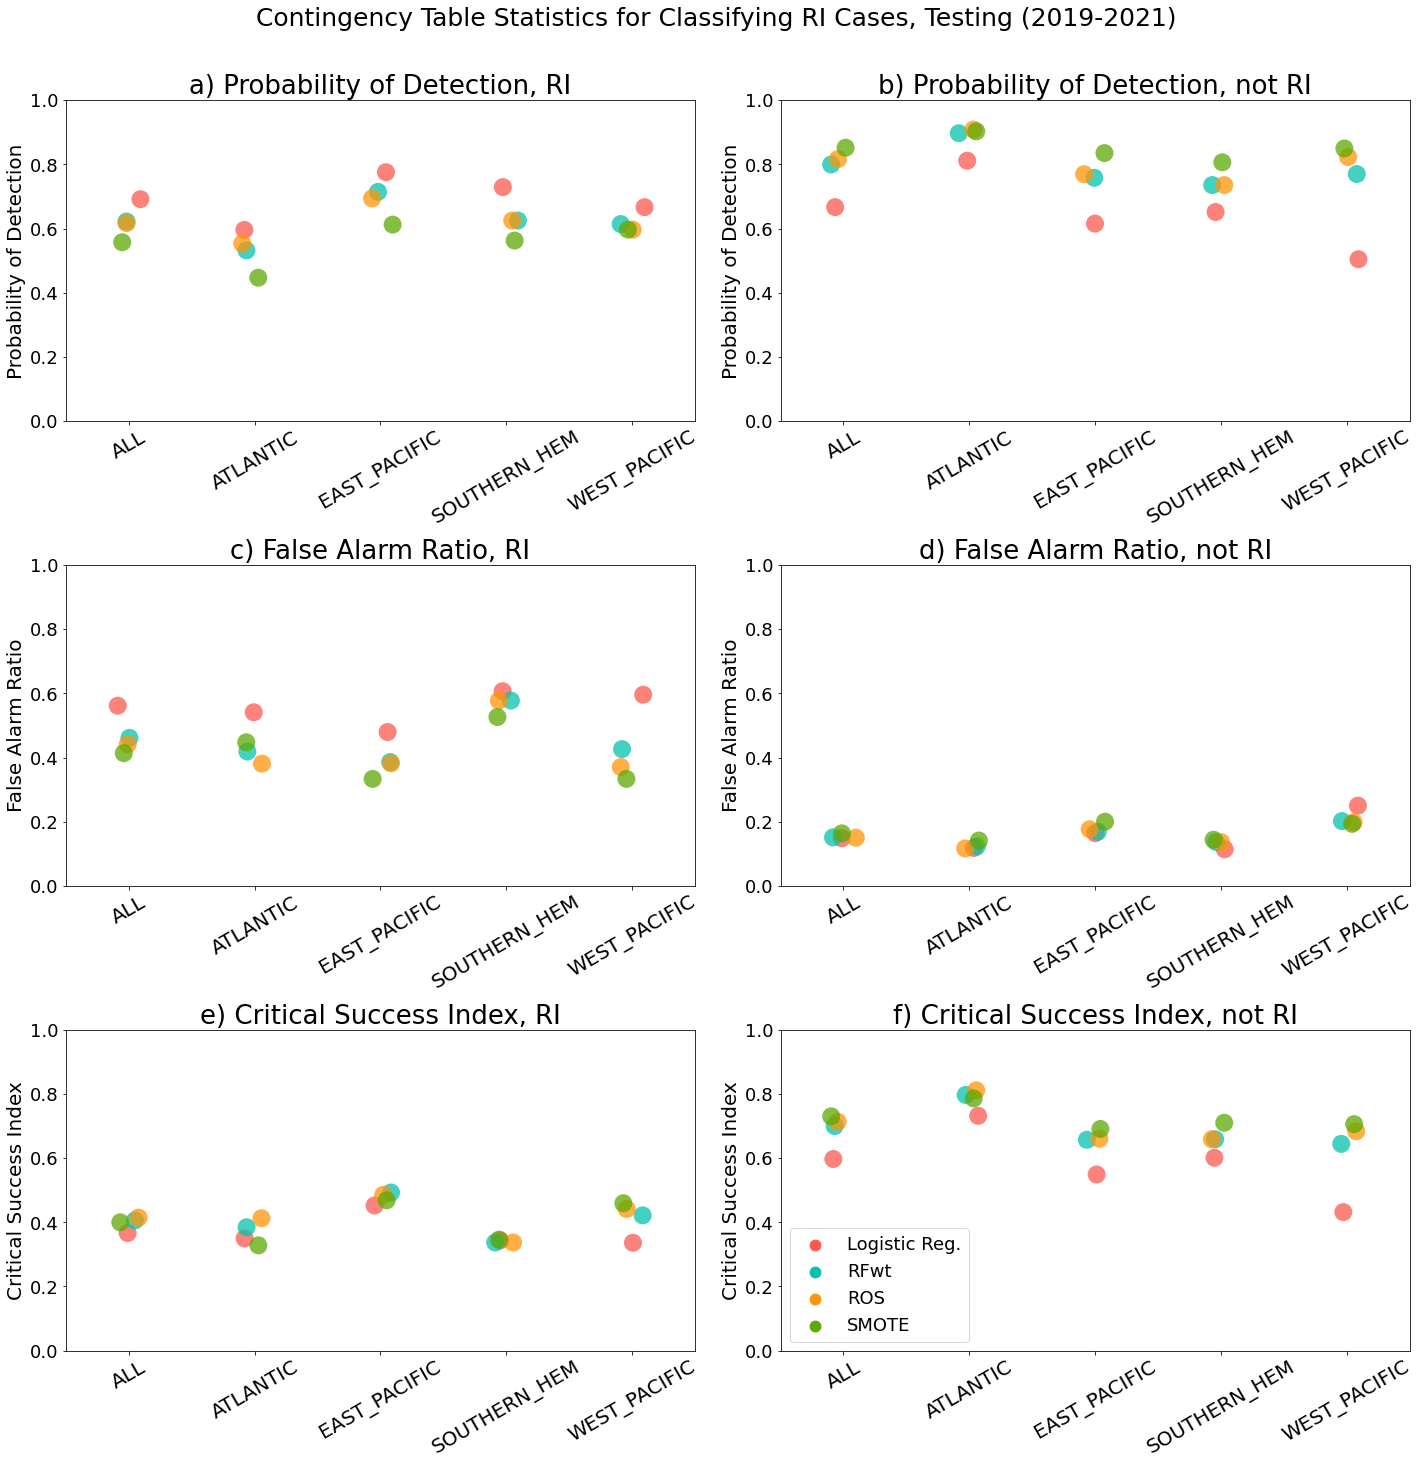

In [18]:
fig6,((ax6a,ax6b),(ax6c,ax6d),(ax6e,ax6f)) = plt.subplots(3,2,figsize=(20,20))
pal_2 = sns.color_palette(sns.xkcd_palette(['coral','turquoise','tangerine','leaf green']),4)
cm_plt = cm_res.set_index(['Category Names'])
cm_plt_total = cm_plt.reset_index().groupby(['Category Names','BASIN','Model','Fold']).mean()
#cm_plt_norm = 
sns.stripplot(data=cm_plt_total.xs('RI').sort_values(['BASIN','Model']).reset_index(),x='BASIN',y='POD',
              hue='Model',ax=ax6a,s=18,alpha=0.75,palette=sns.set_palette(pal_2))
ax6a.set_ylabel('Probability of Detection',fontsize=20)
ax6a.get_legend().remove()
# ax6a.legend(fontsize=12)
ax6a.set_xticklabels(basin_ALL,fontsize=20,rotation=30)
ax6a.set_title('a) Probability of Detection, RI',fontsize=26)
ax6a.set_xlabel(None)
ax6a.set_ylim([0,1])
ax6a.tick_params(axis='y',labelsize=18)
#
sns.stripplot(data=cm_plt.xs('RI').sort_values(['BASIN','Model']).reset_index(),x='BASIN',y='FAR',
              hue='Model',ax=ax6c,s=18,alpha=0.75,palette=sns.set_palette(pal_2))
ax6c.set_ylabel('False Alarm Ratio',fontsize=20)
ax6c.legend(fontsize=12)
ax6c.get_legend().remove()
ax6c.set_xticklabels(basin_ALL,fontsize=20,rotation=30)
ax6c.set_title('c) False Alarm Ratio, RI',fontsize=26)
ax6c.set_xlabel(None)
ax6c.set_ylim([0,1])
ax6c.tick_params(axis='y',labelsize=18)
#
sns.stripplot(data=cm_plt.xs('not RI').sort_values(['BASIN','Model']).reset_index(),
            x='BASIN',y='POD',hue='Model',ax=ax6b,s=18,alpha=0.75,palette=sns.set_palette(pal_2))
ax6b.set_ylabel('Probability of Detection',fontsize=20)
ax6b.legend(fontsize=12)
ax6b.get_legend().remove()
ax6b.set_xticklabels(basin_ALL,fontsize=20,rotation=30)
ax6b.set_title('b) Probability of Detection, not RI',fontsize=26)
ax6b.set_xlabel(None)
ax6b.tick_params(axis='y',labelsize=18)
ax6b.set_ylim([0,1])
#
sns.stripplot(data=cm_plt.xs('not RI').sort_values(['BASIN','Model']).reset_index(),
            x='BASIN',y='FAR',hue='Model',ax=ax6d,s=18,alpha=0.75,palette=sns.set_palette(pal_2))
ax6d.set_ylabel('False Alarm Ratio',fontsize=20)
# ax6d.legend(fontsize=18)
ax6d.get_legend().remove()
ax6d.set_xticklabels(basin_ALL,fontsize=20,rotation=30)
ax6d.set_title('d) False Alarm Ratio, not RI',fontsize=26)
ax6d.set_xlabel(None)
ax6d.tick_params(axis='y',labelsize=18)
ax6d.set_ylim([0,1])
#
sns.stripplot(data=cm_plt.xs('RI').sort_values(['BASIN','Model']).reset_index(),
            x='BASIN',y='Threat',hue='Model',ax=ax6e,s=18,alpha=0.75,palette=sns.set_palette(pal_2))
ax6e.set_ylabel('Critical Success Index',fontsize=20)
#ax6e.legend(fontsize=18)
ax6e.get_legend().remove()
ax6e.set_xticklabels(basin_ALL,fontsize=20,rotation=30)
ax6e.set_title('e) Critical Success Index, RI',fontsize=26)
ax6e.set_xlabel(None)
ax6e.tick_params(axis='y',labelsize=18)
ax6e.set_ylim([0,1])
#
sns.stripplot(data=cm_plt.xs('not RI').sort_values(['BASIN','Model']).reset_index(),
            x='BASIN',y='Threat',hue='Model',ax=ax6f,s=18,alpha=0.75,palette=sns.set_palette(pal_2))
ax6f.set_ylabel('Critical Success Index',fontsize=20)
ax6f.legend(fontsize=18,markerscale=1.4)
ax6f.set_xticklabels(basin_ALL,fontsize=20,rotation=30)
ax6f.set_title('f) Critical Success Index, not RI',fontsize=26)
ax6f.set_xlabel(None)
ax6f.tick_params(axis='y',labelsize=18)
ax6f.set_ylim([0,1])
#
fig6.suptitle('Contingency Table Statistics for Classifying RI Cases, Testing (2019-2021)',fontsize=25,y=1.015)
fig6.tight_layout()
#
fig6.savefig(fig_dir_save+'POD_FAR_CSI_TESTING.png',format='png',dpi=350,bbox_inches='tight')
fig6.savefig(fig_dir_save+'POD_FAR_CSI_TESTING.pdf',format='pdf',bbox_inches='tight')

##### Hits, Misses, False Alarms

In [27]:
# Get total numbers of RI cases in testing sample for each basin (same for every model)
tot_numbers = cm_plt.xs('RI').reset_index().groupby(['BASIN'])['N_actual'].mean().reset_index().sort_values(['BASIN'])

BASIN  N_actual
0           ALL       201
1      ATLANTIC        47
2  EAST_PACIFIC        49
3  SOUTHERN_HEM        48
4  WEST_PACIFIC        57

In [34]:
tot_numbers_plot = tot_numbers['BASIN']+' (N='+tot_numbers['N_actual'].astype(str)+')'


In [35]:
tot_numbers_plot

0            ALL (N=201)
1        ATLANTIC (N=47)
2    EAST_PACIFIC (N=49)
3    SOUTHERN_HEM (N=48)
4    WEST_PACIFIC (N=57)
dtype: object

In [ ]:
fig2,((ax2a,ax2b),(ax2c,ax2d),(ax2e,ax2f)) = plt.subplots(3,2,figsize=(17,17))
sns.stripplot(data=cm_plt_total.xs('RI').sort_values(['BASIN','Model']).reset_index(),x='BASIN',y='Hits',
              hue='Model',ax=ax2a,jitter=0.25,s=18,alpha=0.7,palette=sns.set_palette(pal_2))
ax2a.set_ylabel('Hits',fontsize=20)
ax2a.get_legend().remove()
ax2a.grid()
# ax6a.legend(fontsize=12)
ax2a.set_xticklabels(tot_numbers_plot,fontsize=18,rotation=30)
ax2a.set_title('a) Hits, RI',fontsize=26)
ax2a.set_xlabel(None)
# ax6a.set_ylim([0,1])
ax2a.tick_params(axis='y',labelsize=18)

#
sns.stripplot(data=cm_plt.xs('RI').sort_values(['BASIN','Model']).reset_index(),x='BASIN',y='Misses',
              hue='Model',ax=ax2c,jitter=0.25,s=18,alpha=0.7,palette=sns.set_palette(pal_2))
ax2c.set_ylabel('Misses',fontsize=20)
ax2c.grid()
ax2c.legend(fontsize=12)
ax2c.get_legend().remove()
ax2c.set_xticklabels(tot_numbers_plot,fontsize=18,rotation=30)
ax2c.set_title('c) Misses, RI',fontsize=26)
ax2c.set_xlabel(None)
# ax6c.set_ylim([0,1])
ax2c.tick_params(axis='y',labelsize=18)
#
sns.stripplot(data=cm_plt.xs('not RI').sort_values(['BASIN','Model']).reset_index(),
            x='BASIN',y='Hits',hue='Model',ax=ax2b,jitter=0.25,s=18,alpha=0.7,palette=sns.set_palette(pal_2))
ax2b.set_ylabel('Hits',fontsize=20)
ax2b.legend(fontsize=12)
ax2b.grid()
ax2b.get_legend().remove()
ax2b.set_xticklabels(tot_numbers_plot,fontsize=18,rotation=30)
ax2b.set_title('b) Hits, not RI',fontsize=26)
ax2b.set_xlabel(None)
ax2b.tick_params(axis='y',labelsize=18)
# ax6b.set_ylim([0,1])
#
sns.stripplot(data=cm_plt.xs('not RI').sort_values(['BASIN','Model']).reset_index(),
            x='BASIN',y='Misses',hue='Model',ax=ax2d,jitter=0.25,s=18,alpha=0.7,palette=sns.set_palette(pal_2))
ax2d.set_ylabel('Misses',fontsize=20)
# ax6d.legend(fontsize=18)
ax2d.get_legend().remove()
ax2d.grid()
ax2d.set_xticklabels(tot_numbers_plot,fontsize=18,rotation=30)
ax2d.set_title('d) Misses, not RI',fontsize=26)
ax2d.set_xlabel(None)
ax2d.tick_params(axis='y',labelsize=18)
# ax6d.set_ylim([0,1])
#
sns.stripplot(data=cm_plt.xs('RI').sort_values(['BASIN','Model']).reset_index(),
            x='BASIN',y='False Alarms',hue='Model',ax=ax2e,jitter=0.25,s=18,alpha=0.7,palette=sns.set_palette(pal_2))
ax2e.set_ylabel('False Alarms',fontsize=20)
#ax6e.legend(fontsize=18)
ax2e.get_legend().remove()
ax2e.grid()
ax2e.set_xticklabels(tot_numbers_plot,fontsize=18,rotation=30)
ax2e.set_title('e) False Alarms, RI',fontsize=26)
ax2e.set_xlabel(None)
ax2e.tick_params(axis='y',labelsize=18)
# ax6e.set_ylim([0,1])
#
sns.stripplot(data=cm_plt.xs('not RI').sort_values(['BASIN','Model']).reset_index(),
            x='BASIN',y='False Alarms',hue='Model',ax=ax2f,jitter=0.25,s=18,alpha=0.7,palette=sns.set_palette(pal_2))
ax2f.set_ylabel('False Alarms',fontsize=20)
ax2f.legend(fontsize=18,markerscale=1.4)
ax2f.set_xticklabels(tot_numbers_plot,fontsize=18,rotation=30)
ax2f.set_title('f) False Alarms, not RI',fontsize=26)
ax2f.set_xlabel(None)
ax2f.grid()
ax2f.tick_params(axis='y',labelsize=18)
# ax6f.set_ylim([0,1])
#
fig2.suptitle('Hits, Misses, and False Alarms, Classifying RI Cases, Testing (2019-2021)',fontsize=25,y=1.015)
fig2.tight_layout()
#
fig2.savefig(fig_dir_save+'HIT_MISS_FA_TESTING.png',format='png',dpi=350,bbox_inches='tight')
fig2.savefig(fig_dir_save+'HIT_MISS_FA_TESTING.pdf',format='pdf',bbox_inches='tight')

##### Load precision vs recall curves

In [11]:
prec_vs_rec = pd.read_csv(fpath_load+'Prec_vs_recall'+path_suff)
prec_vs_rec['Model'] = prec_vs_rec['Model'].replace({'Random Forest (SMOTE)':'SMOTE',
                                          'Random Forest (random oversample)':'ROS',
                                          'Random Forest (class wt)':'RFwt'})


##### Get performance diagram curves from precision vs recall data

/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_plotting.py:214: UserWarning: The following kwargs were not used by contour: 'axes'
  ax.contourf(success_ratio_matrix, pod_matrix, csi_matrix,
/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_plotting.py:229: UserWarning: The following kwargs were not used by contour: 'axes'
  bias_contour_object = ax.contour(
/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_plotting.py:214: UserWarning: The following kwargs were not used by contour: 'axes'
  ax.contourf(success_ratio_matrix, pod_matrix, csi_matrix,
/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_plotting.py:229: UserWarning: The following kwargs were not used by contour: 'axes'
  bias_contour_object = ax.contour(
/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_plotting.py:214: UserWarning: The following kwargs were not used by contour: 'axes'
  ax.contourf(success_ratio_matrix, pod_matrix, csi_matrix,
/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_plotting.py:229: UserWarning: The following kwargs were no

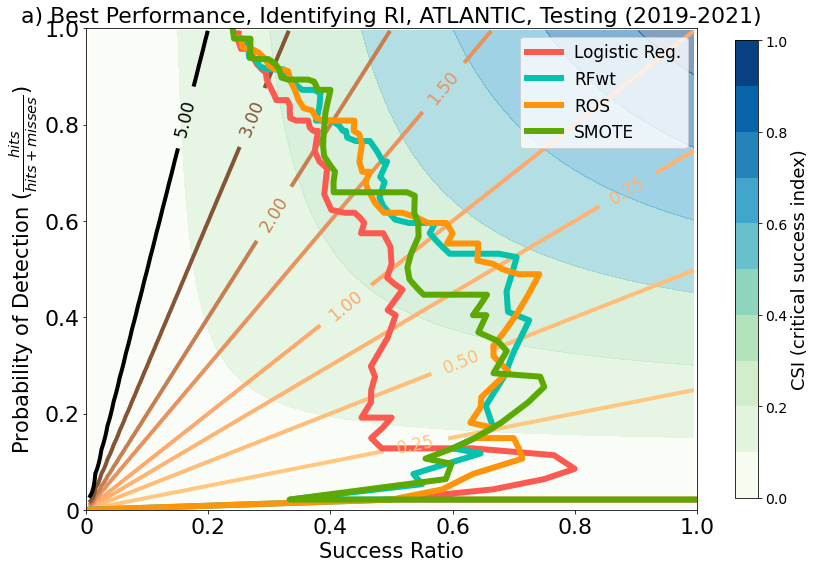

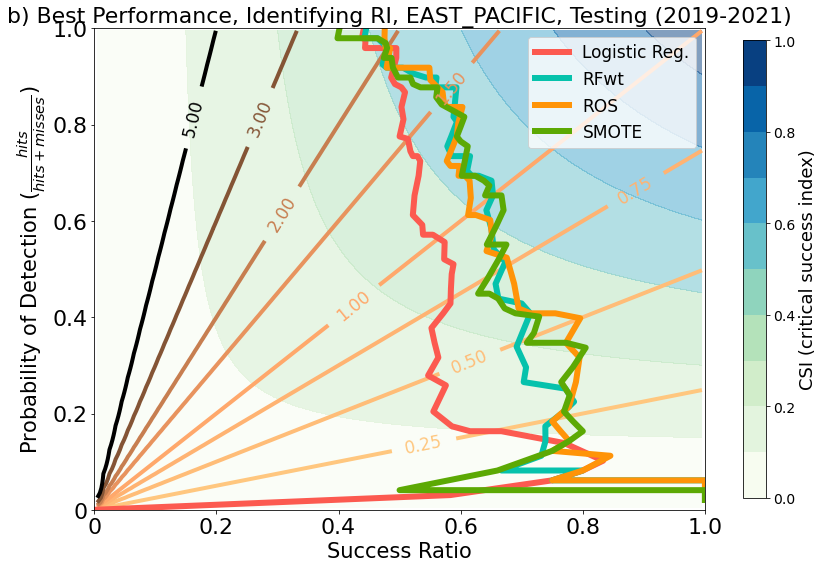

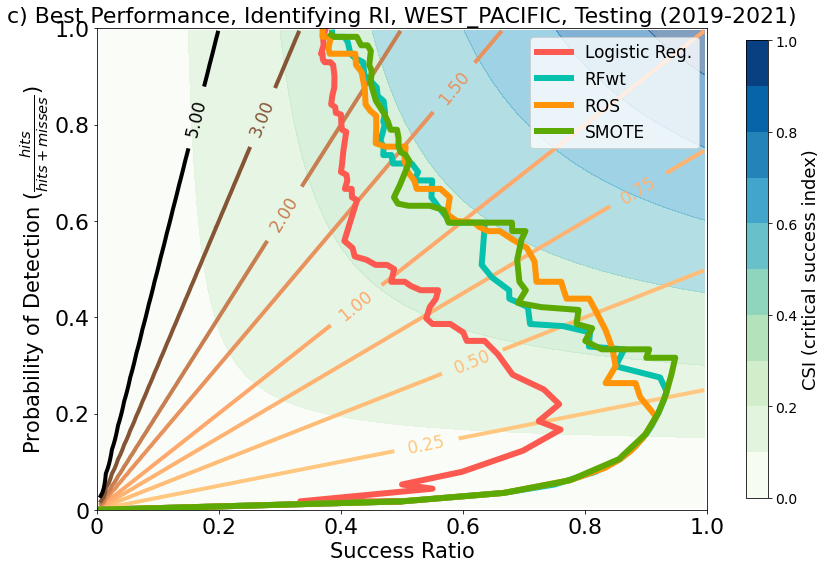

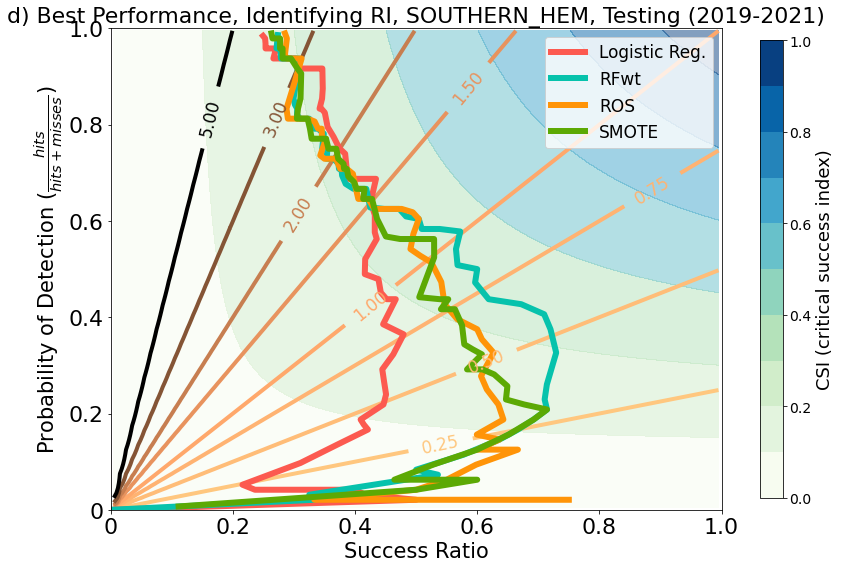

In [12]:
pd_curves = SHIPS_ML_model_funcs.calculate_PD_curves(prec_vs_rec)
metric_plt = 'max'
basin_use = ['ATLANTIC','EAST_PACIFIC','WEST_PACIFIC','SOUTHERN_HEM']
basin_label = ['a)','b)','c)','d)']
for ibasin in np.arange(0,len(basin_use)):
    basin_sel = basin_use[ibasin]
    basin_lett = basin_label[ibasin]
    fig3,ax3 = plt.subplots(1,1,figsize=(12,8))
    SHIPS_plotting.make_performance_diagram_background(ax3)
    SHIPS_plotting.plot_PD_curves_compare_models(prec_vs_rec,ax3,basin_sel,metric_plt)
    ax3.set_title('{lett} Best Performance, Identifying RI, {basin}, Testing (2019-2021)'.format(
        lett=basin_lett,basin=basin_sel),fontsize=22)
    fig3.tight_layout()
    fig3.savefig(fig_dir_save+'PD_curves_best_{basin}_TEST.png'.format(basin=basin_sel),format='png',dpi=350,bbox_inches='tight')
    fig3.savefig(fig_dir_save+'PD_curves_best_{basin}_TEST.pdf'.format(basin=basin_sel),format='pdf',bbox_inches='tight')

/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_plotting.py:214: UserWarning: The following kwargs were not used by contour: 'axes'
  ax.contourf(success_ratio_matrix, pod_matrix, csi_matrix,
/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_plotting.py:229: UserWarning: The following kwargs were not used by contour: 'axes'
  bias_contour_object = ax.contour(


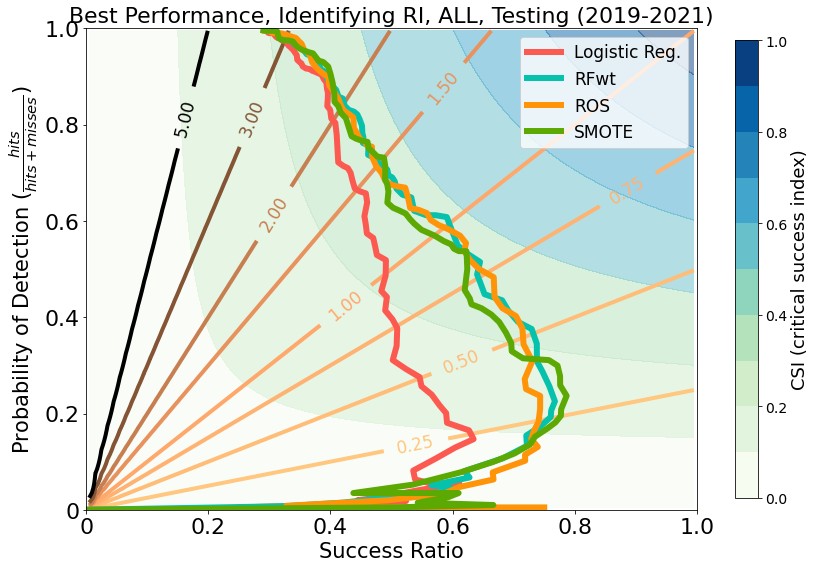

In [13]:
fig3,ax3 = plt.subplots(1,1,figsize=(12,8))
SHIPS_plotting.make_performance_diagram_background(ax3)
SHIPS_plotting.plot_PD_curves_compare_models(prec_vs_rec,ax3,'ALL',metric_plt)
ax3.set_title('Best Performance, Identifying RI, {basin}, Testing (2019-2021)'.format(
        basin='ALL'),fontsize=22)
fig3.tight_layout()
fig3.savefig(fig_dir_save+'PD_curves_best_{basin}_TEST.png'.format(basin='ALL'),format='png',dpi=350,bbox_inches='tight')
fig3.savefig(fig_dir_save+'PD_curves_best_{basin}_TEST.pdf'.format(basin='ALL'),format='pdf',bbox_inches='tight')

##### All 5 panels together

/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_plotting.py:214: UserWarning: The following kwargs were not used by contour: 'axes'
  ax.contourf(success_ratio_matrix, pod_matrix, csi_matrix,
/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_plotting.py:229: UserWarning: The following kwargs were not used by contour: 'axes'
  bias_contour_object = ax.contour(
/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_plotting.py:214: UserWarning: The following kwargs were not used by contour: 'axes'
  ax.contourf(success_ratio_matrix, pod_matrix, csi_matrix,
/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_plotting.py:229: UserWarning: The following kwargs were not used by contour: 'axes'
  bias_contour_object = ax.contour(
/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_plotting.py:214: UserWarning: The following kwargs were not used by contour: 'axes'
  ax.contourf(success_ratio_matrix, pod_matrix, csi_matrix,
/local/home/mmcgraw/ML_for_TC_RI/utils/SHIPS_plotting.py:229: UserWarning: The following kwargs were no

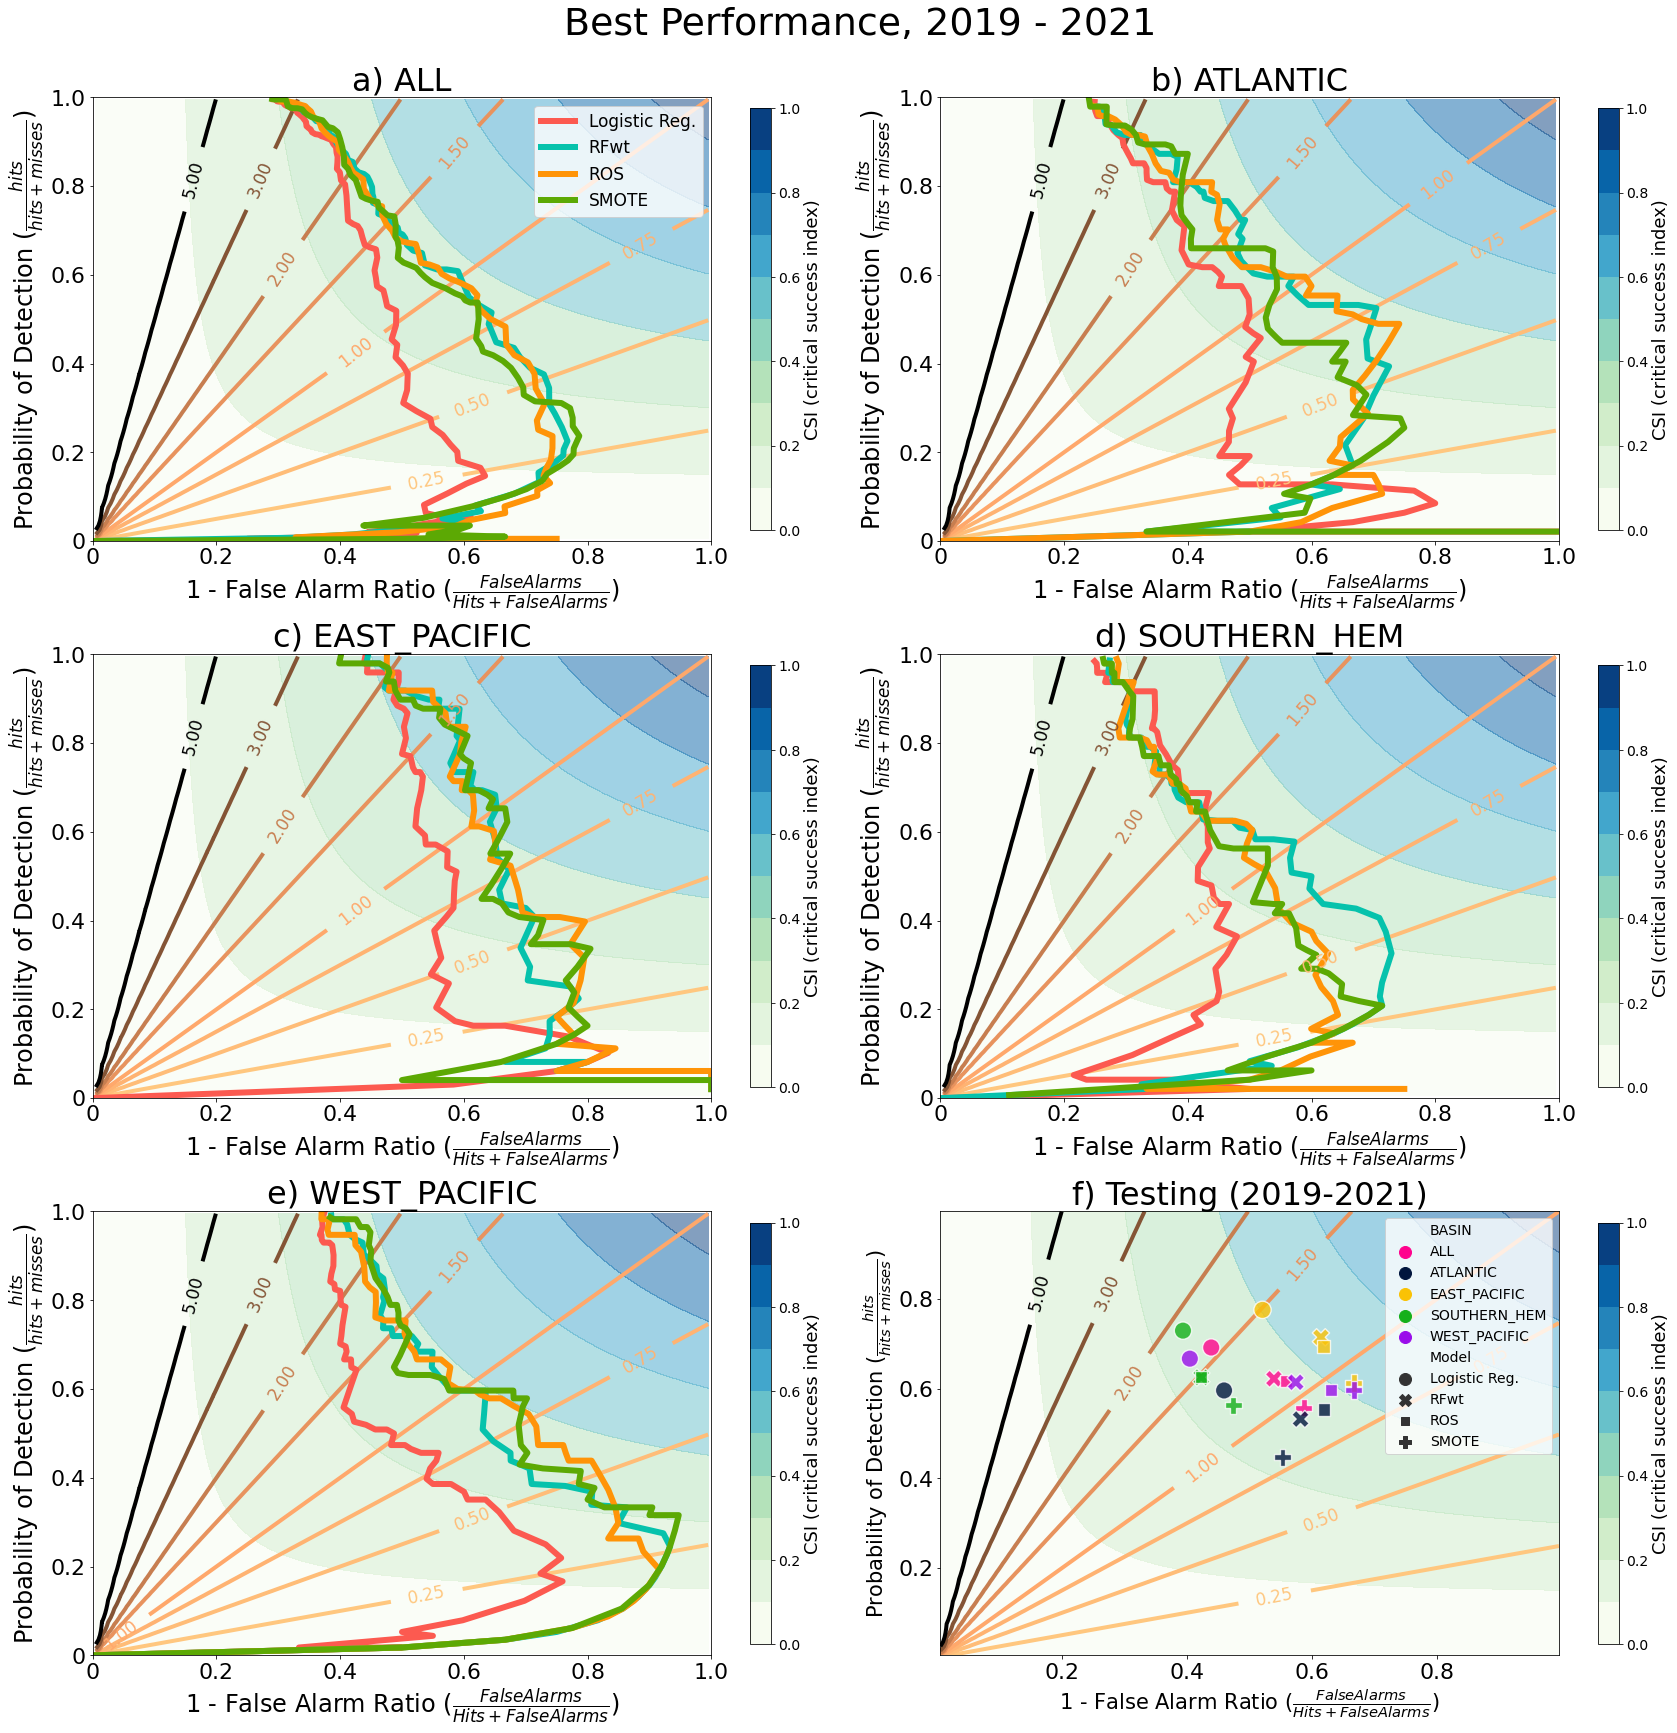

In [14]:
fig13,ax13 = plt.subplots(3,2,figsize=(24,24))
ax_sel = ax13.flatten()
letters = ['a)','b)','c)','d)','e)','f)']
for i in np.arange(0,len(ax_sel)):
    iax = ax_sel[i]
    if i == 5:
        SHIPS_plotting.make_performance_diagram_background(iax)
        SHIPS_plotting.add_model_results(iax,cm_res)
        iax.set_title('{lett} Testing (2019-2021)'.format(lett=letters[i]),fontsize=32)
        iax.legend(fontsize=14,markerscale=2)
    else:
        SHIPS_plotting.make_performance_diagram_background(iax)
        SHIPS_plotting.plot_PD_curves_compare_models(prec_vs_rec,iax,basin_ALL[i],metric_plt)
        iax.set_ylabel(r"Probability of Detection (${\frac{hits}{hits+misses}})$",fontsize=24)
        iax.set_xlabel(r"1 - False Alarm Ratio (${\frac{False Alarms}{Hits + False Alarms}})$",fontsize=24)
        iax.set_title('{lett} {basin}'.format(lett=letters[i],basin=basin_ALL[i]),fontsize=32)
        if i != 0:
            iax.get_legend().remove()
#
#fig13.delaxes(ax_sel[5])
fig13.suptitle('Best Performance, 2019 - 2021',fontsize=38,y=1.001)

fig13.tight_layout()
fig13.savefig(fig_dir_save+'PD_curves_best_all_panels_TEST.png',format='png',dpi=350,bbox_inches='tight')
fig13.savefig(fig_dir_save+'PD_curves_best_all_panels_TEST.pdf',format='pdf',bbox_inches='tight')

#### Precision vs recall curves

In [15]:
p_vs_r = prec_vs_rec.set_index(['CLASS','BASIN','Model']).xs('RI')
p_vs_r['Pr'] = p_vs_r['Precision'].round(2)
p_vs_r['Rr'] = p_vs_r['Recall'].round(2)

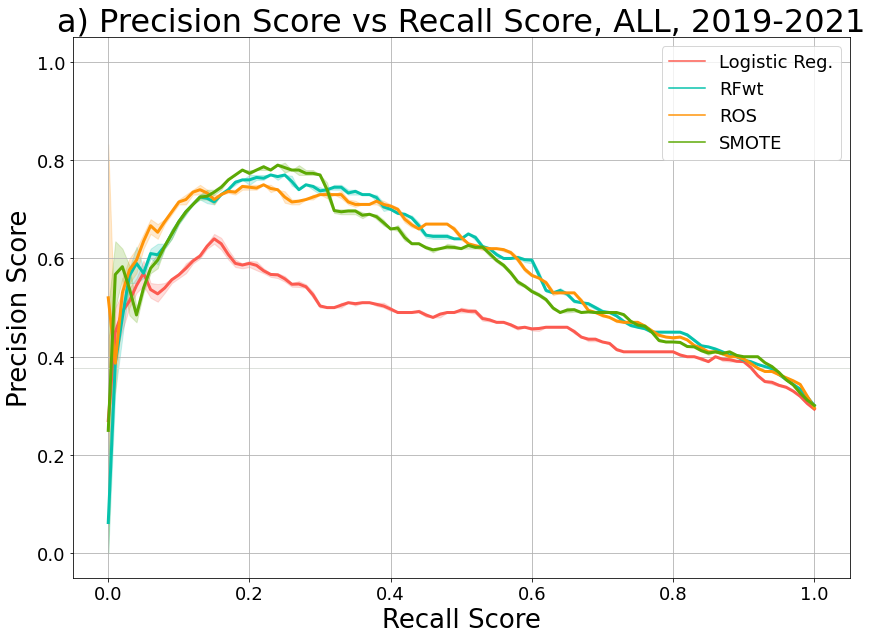

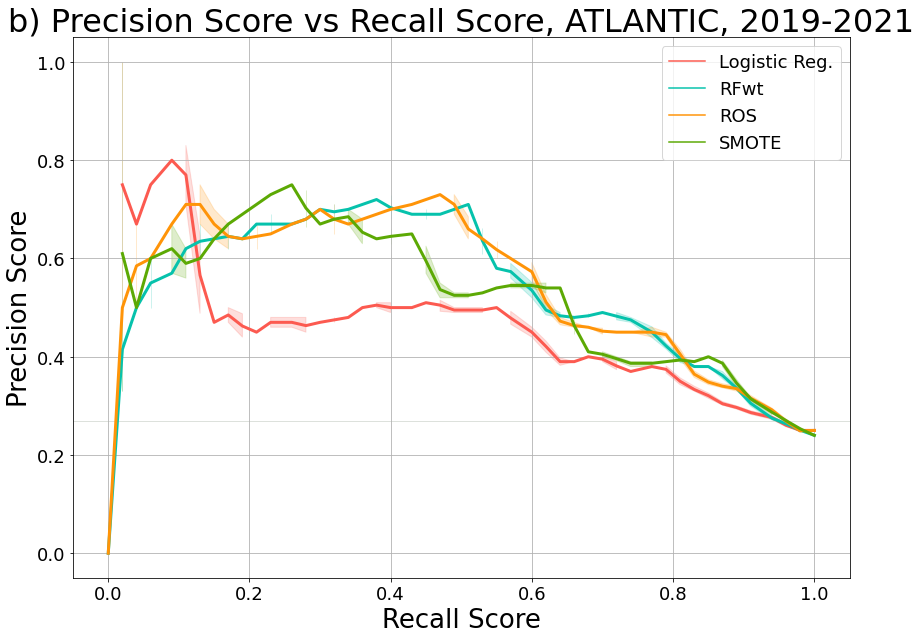

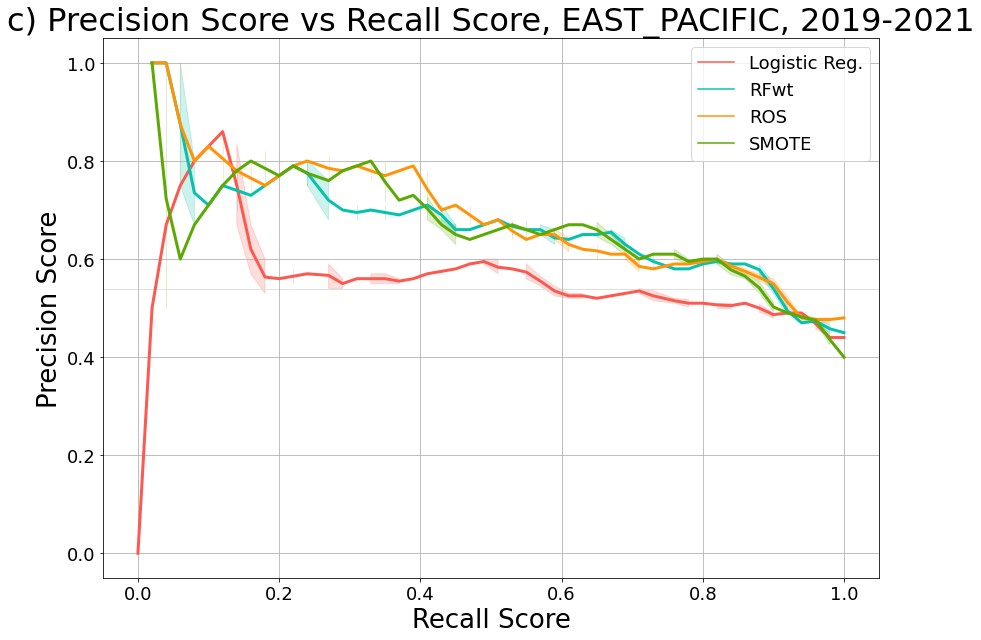

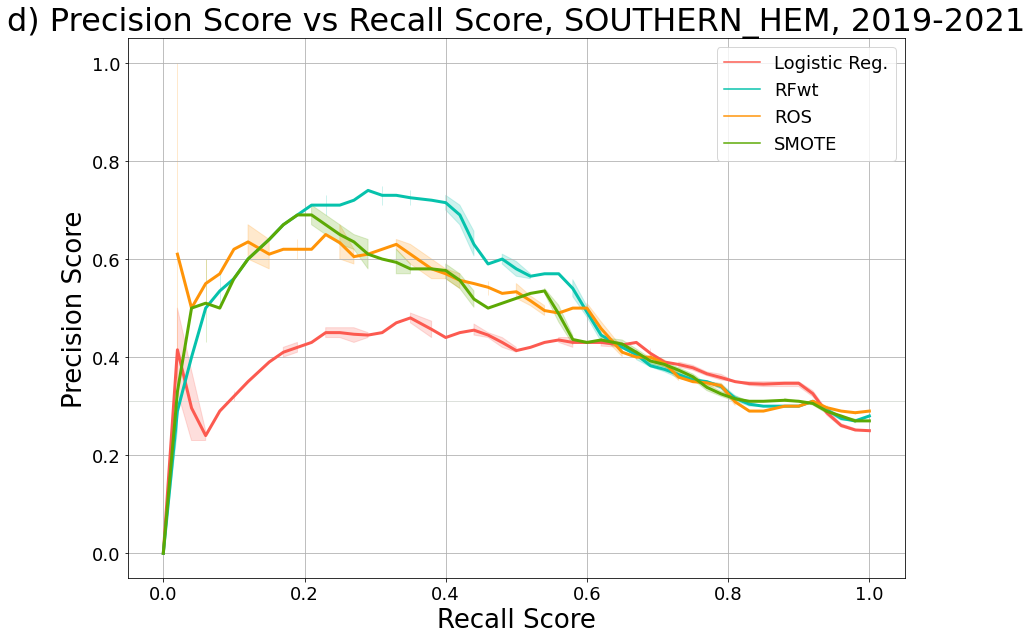

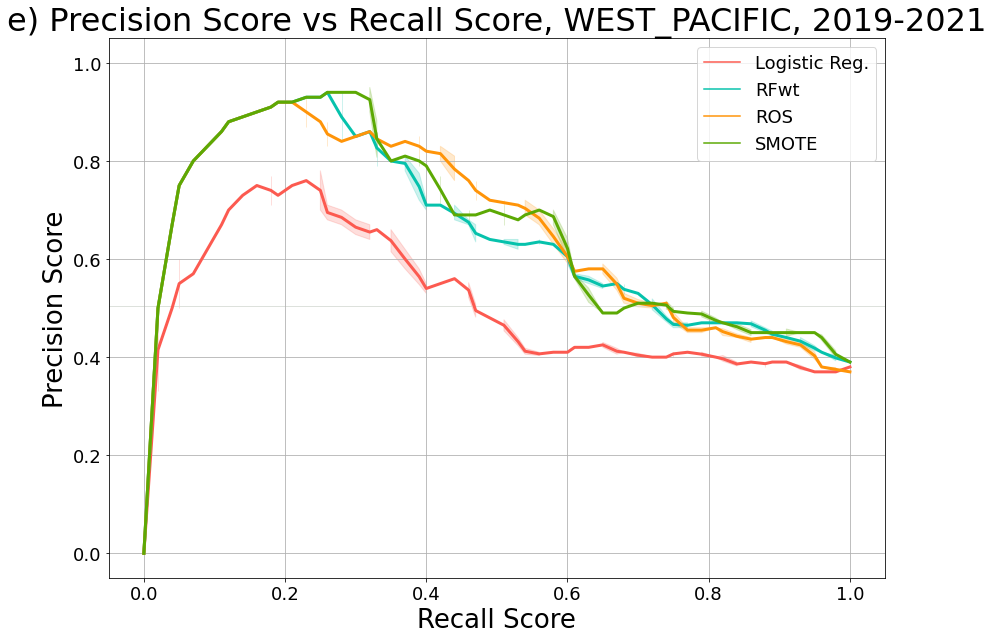

In [16]:
lett = ['a)','b)','c)','d)','e)']
for isel in np.arange(0,len(basin_ALL)):
#
    ibasin = basin_ALL[isel]
    ilett = lett[isel]
    fig6,ax6 = plt.subplots(1,1,figsize=(12,9))
    sns.lineplot(data=p_vs_r.xs(ibasin).reset_index().sort_values(by='Model'),x='Rr',y='Pr',hue='Model',
             palette=sns.set_palette(pal_2),ax=ax6,
            linewidth=3)
    ax6.legend(fontsize=18)
    ax6.set_ylim([-0.05,1.05])
    ax6.set_xlabel('Recall Score',fontsize=26)
    ax6.set_ylabel('Precision Score',fontsize=26)
    ax6.tick_params(axis='x',labelsize=18)
    ax6.tick_params(axis='y',labelsize=18)
    base_max = baselines.xs(ibasin).max()
    base_min = baselines.xs(ibasin).min()
    ax6.grid()
    ax6.axhspan(base_min,base_max,0,1,color='xkcd:light grey',alpha=0.85,label='Baseline')
    ax6.set_title('{ilett} Precision Score vs Recall Score, {basin}, 2019-2021'.format(ilett=ilett,basin=ibasin),
                  fontsize=32)
    #
    fig6.tight_layout()
    fig6.savefig(fig_dir_save+'prec_vs_rec_{basin}_TEST.png'.format(basin=ibasin),format='png',dpi=350,bbox_inches='tight')
    fig6.savefig(fig_dir_save+'prec_vs_rec_{basin}_TEST.pdf'.format(basin=ibasin),format='pdf',bbox_inches='tight')

##### All panels, precision-recall

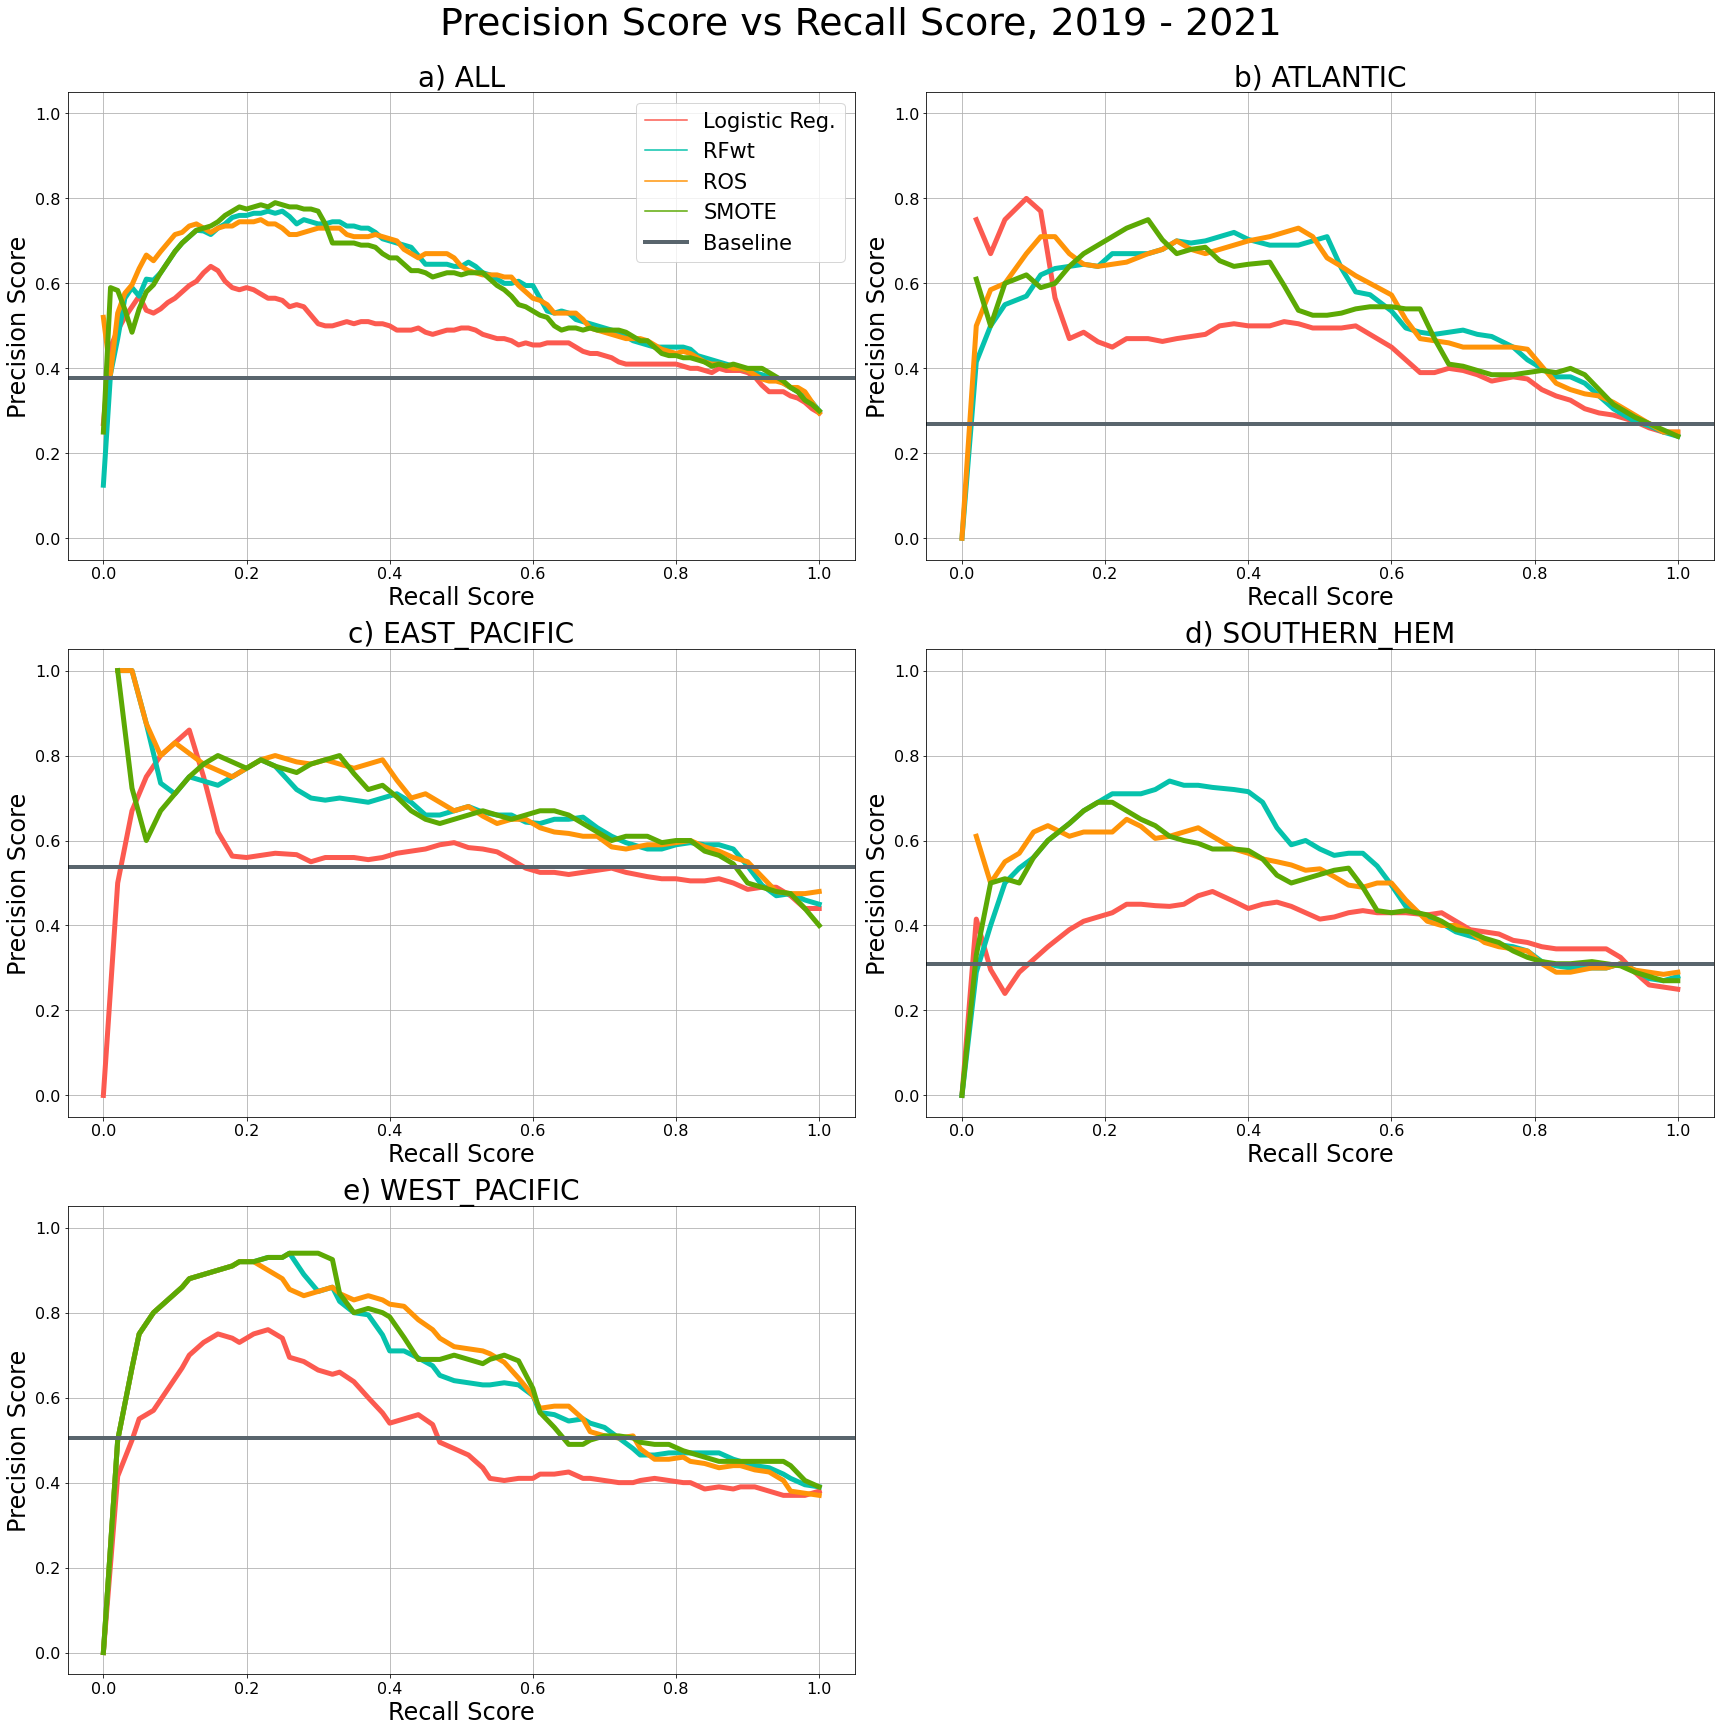

In [17]:
fig16,ax16 = plt.subplots(3,2,figsize=(24,24))
ax_sel = ax16.flatten()
for j in np.arange(0,len(ax_sel)-1):
    iax = ax_sel[j]
   # for isel in np.arange(0,len(basin_ALL)):
#
    ibasin = basin_ALL[j]
    ilett = lett[j]
    #
    sns.lineplot(data=p_vs_r.xs(ibasin).reset_index().groupby(['Model','Rr','Pr']).mean().reset_index().sort_values(by='Model'),
                 x='Rr',y='Pr',hue='Model',palette=sns.set_palette(pal_2),ax=iax,linewidth=5,ci=None)
    iax.set_ylim([-0.05,1.05])
    iax.set_xlabel('Recall Score',fontsize=24)
    iax.set_ylabel('Precision Score',fontsize=24)
    iax.tick_params(axis='x',labelsize=16)
    iax.tick_params(axis='y',labelsize=16)
    #base_max = baselines.xs(ibasin).max()
    #base_min = baselines.xs(ibasin).min()
    iax.grid()
    iax.axhline(baselines.xs(ibasin).mean(),color='xkcd:slate grey',linewidth=4,label='Baseline')
    iax.legend(fontsize=21)
    #
    if j != 0:
        iax.get_legend().remove()
    #
    iax.set_title('{ilett} {ibasin}'.format(ilett=ilett,ibasin=ibasin),fontsize=28)
        #iax.set_title('{ilett} ROC-AUC Curve, {ibasin}, 2019-2021'.format(ilett=ilett,ibasin=ibasin),fontsize=24)
    #
fig16.delaxes(ax_sel[5])
fig16.suptitle('Precision Score vs Recall Score, 2019 - 2021',fontsize=38,y=1.0001)
fig16.tight_layout()
fig16.savefig(fig_dir_save+'prec_vs_rec_all_panels_TEST.png',format='png',dpi=350,bbox_inches='tight')
fig16.savefig(fig_dir_save+'prec_vs_rec_all_panels_TEST.pdf',format='pdf',bbox_inches='tight')


In [18]:
p_vs_r.xs(ibasin).reset_index().groupby(['Model','Rr','Pr']).mean().reset_index().sort_values(by='Model')

Model    Rr    Pr  Unnamed: 0    Recall  Cutoff Threshold  \
0    Logistic Reg.  0.00  0.00       151.0  0.000000          0.351146   
80   Logistic Reg.  0.67  0.41        59.5  0.666667          0.351146   
79   Logistic Reg.  0.67  0.40        58.0  0.666667          0.351146   
78   Logistic Reg.  0.65  0.43        65.5  0.649123          0.351146   
77   Logistic Reg.  0.65  0.42        63.5  0.649123          0.351146   
..             ...   ...   ...         ...       ...               ...   
370          SMOTE  0.42  0.71       114.0  0.421053          0.519232   
369          SMOTE  0.42  0.69       113.0  0.421053          0.519232   
368          SMOTE  0.40  0.79       119.0  0.403509          0.519232   
394          SMOTE  0.60  0.62        93.0  0.596491          0.519232   
451          SMOTE  1.00  0.39         0.0  1.000000          0.519232   

     Precision  Thresholds        F1  Fold       POD       FAR  Success Ratio  \
0     0.000000    0.972646       NaN   0.0  0.000000  1.000000       0.000000   
80    0.410823    0.505091  0.508367   0.0  0.666667  0.589177       0.410823   
79    0.404255    0.503814  0.503311   0.0  0.666667  0.595745       0.404255   
78    0.427760    0.527763  0.515686   0.0  0.649123  0.572240       0.427760   
77    0.418092    0.519693  0.508597   0.0  0.649123  0.581908       0.418092   
..         ...         ...       ...   ...       ...       ...            ...   
370   0.705882    0.595128  0.527473   0.0  0.421053  0.294118       0.705882   
369   0.685714    0.594359  0.521739   0.0  0.421053  0.314286       0.685714   
368   0.793103    0.614359  0.534884   0.0  0.403509  0.206897       0.793103   
394   0.618182    0.485341  0.607143   0.0  0.596491  0.381818       0.618182   
451   0.385135    0.155592  0.556098   0.0  1.000000  0.614865       0.385135   

          CSI      Bias  Thresh Round  
0    0.000000       NaN         0.970  
80   0.340814  1.622807         0.505  
79   0.336283  1.649123         0.500  
78   0.347425  1.517544         0.530  
77   0.341021  1.552632         0.520  
..        ...       ...           ...  
370  0.358209  0.596491         0.600  
369  0.352941  0.614035         0.590  
368  0.365079  0.508772         0.610  
394  0.435897  0.964912         0.490  
451  0.385135  2.596491         0.160  

[452 rows x 16 columns]

#### AUC/ROC score

In [19]:
baselines.xs(ibasin)[0]

0.504424778761062

In [20]:
roc_auc = cm_res = pd.read_csv(fpath_load+'ROC_AUC_vals'+path_suff)
roc_auc['Model'] = roc_auc['Model'].replace({'Random Forest (SMOTE)':'SMOTE',
                                          'Random Forest (random oversample)':'ROS',
                                          'Random Forest (class wt)':'RFwt'})

# basin_sel = 'ALL'
models_ALL = roc_auc.sort_values(by='Model')['Model'].unique()

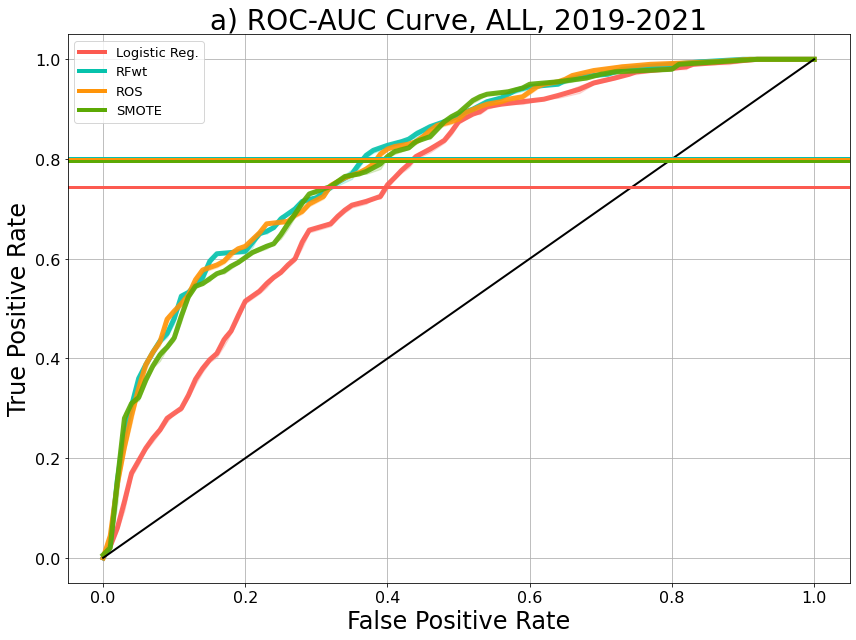

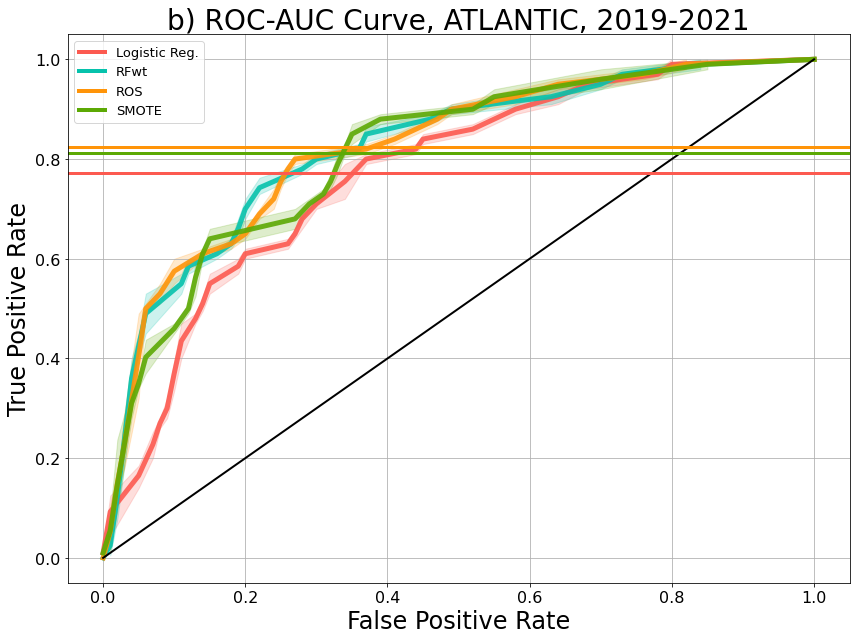

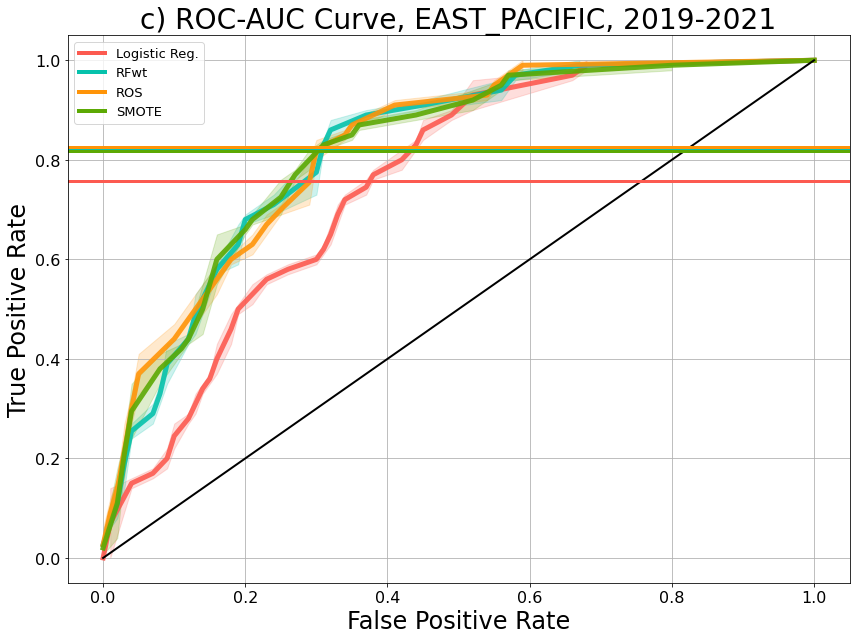

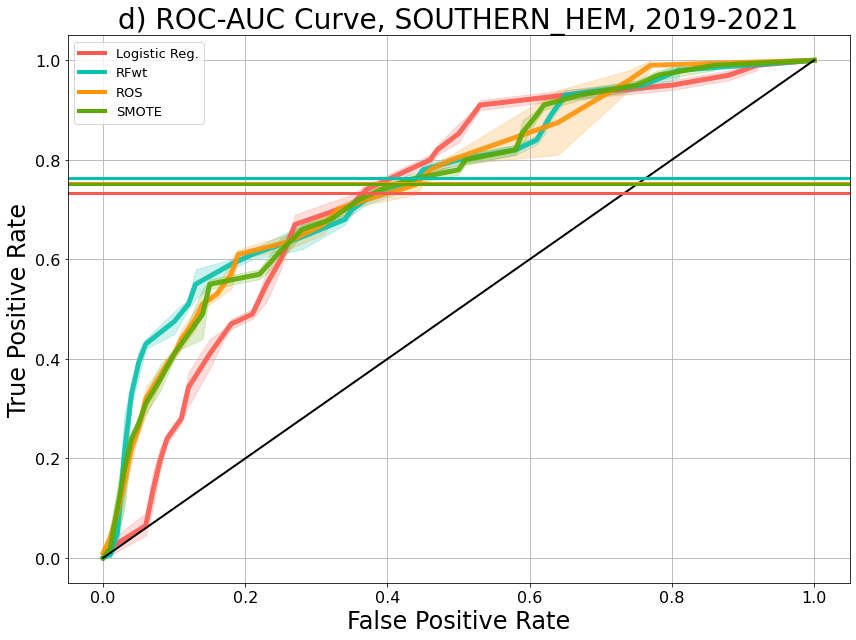

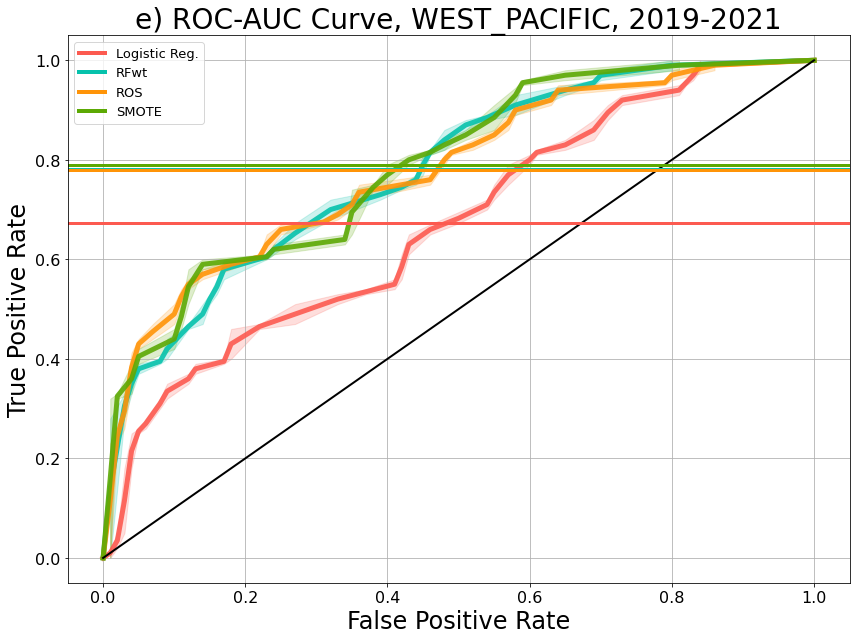

In [21]:
for isel in np.arange(0,len(basin_ALL)):
#
    ibasin = basin_ALL[isel]
    ilett = lett[isel]
    #
    roc_vals_plt = roc_auc.set_index(['BASIN']).xs(ibasin).reset_index()
    roc_vals_plt[['FPR round','TPR round']] = roc_vals_plt[['False Positive Rate','True Positive Rate']].round(2)
    # 
    fig7,ax7 = plt.subplots(1,1,figsize=(12,9))
    # use_pal = sns.set_palette({'xkcd:turquoise','xkcd:coral','xkcd:tangerine','xkcd:leaf green'})
    sns.lineplot(data=roc_vals_plt.sort_values(by='Model'),x='FPR round',y='TPR round',hue='Model',ax=ax7,
                palette=sns.set_palette(pal_2),alpha=0.9,linewidth=5)
    ax7.plot([0,1],[0,1],color='k',linewidth=2)
    ax7.set_xlabel('False Positive Rate',fontsize=24)
    ax7.set_ylabel('True Positive Rate',fontsize=24)
    ax7.tick_params(axis='x',labelsize=16)
    ax7.tick_params(axis='y',labelsize=16)
    leg1 = ax7.legend(fontsize=13)
    for line in leg1.get_lines():
        line.set_linewidth(4.0)
    ax7.grid()
    #
    for imod in np.arange(0,len(models_ALL)):
        ax7.axhline(y=roc_vals_plt.groupby(['Model'])['AUC ROC Score'].max().iloc[imod],color=sns.color_palette()[imod],
                   linewidth=3)
    ax7.set_title('{ilett} ROC-AUC Curve, {ibasin}, 2019-2021'.format(ilett=ilett,ibasin=ibasin),fontsize=28)
    #
    fig7.tight_layout()
    fig7.savefig(fig_dir_save+'roc_auc_{basin}_TEST.png'.format(basin=ibasin),format='png',dpi=350,bbox_inches='tight')
    fig7.savefig(fig_dir_save+'roc_auc_{basin}_TEST.pdf'.format(basin=ibasin),format='pdf',bbox_inches='tight')

##### ROC curves for all panels

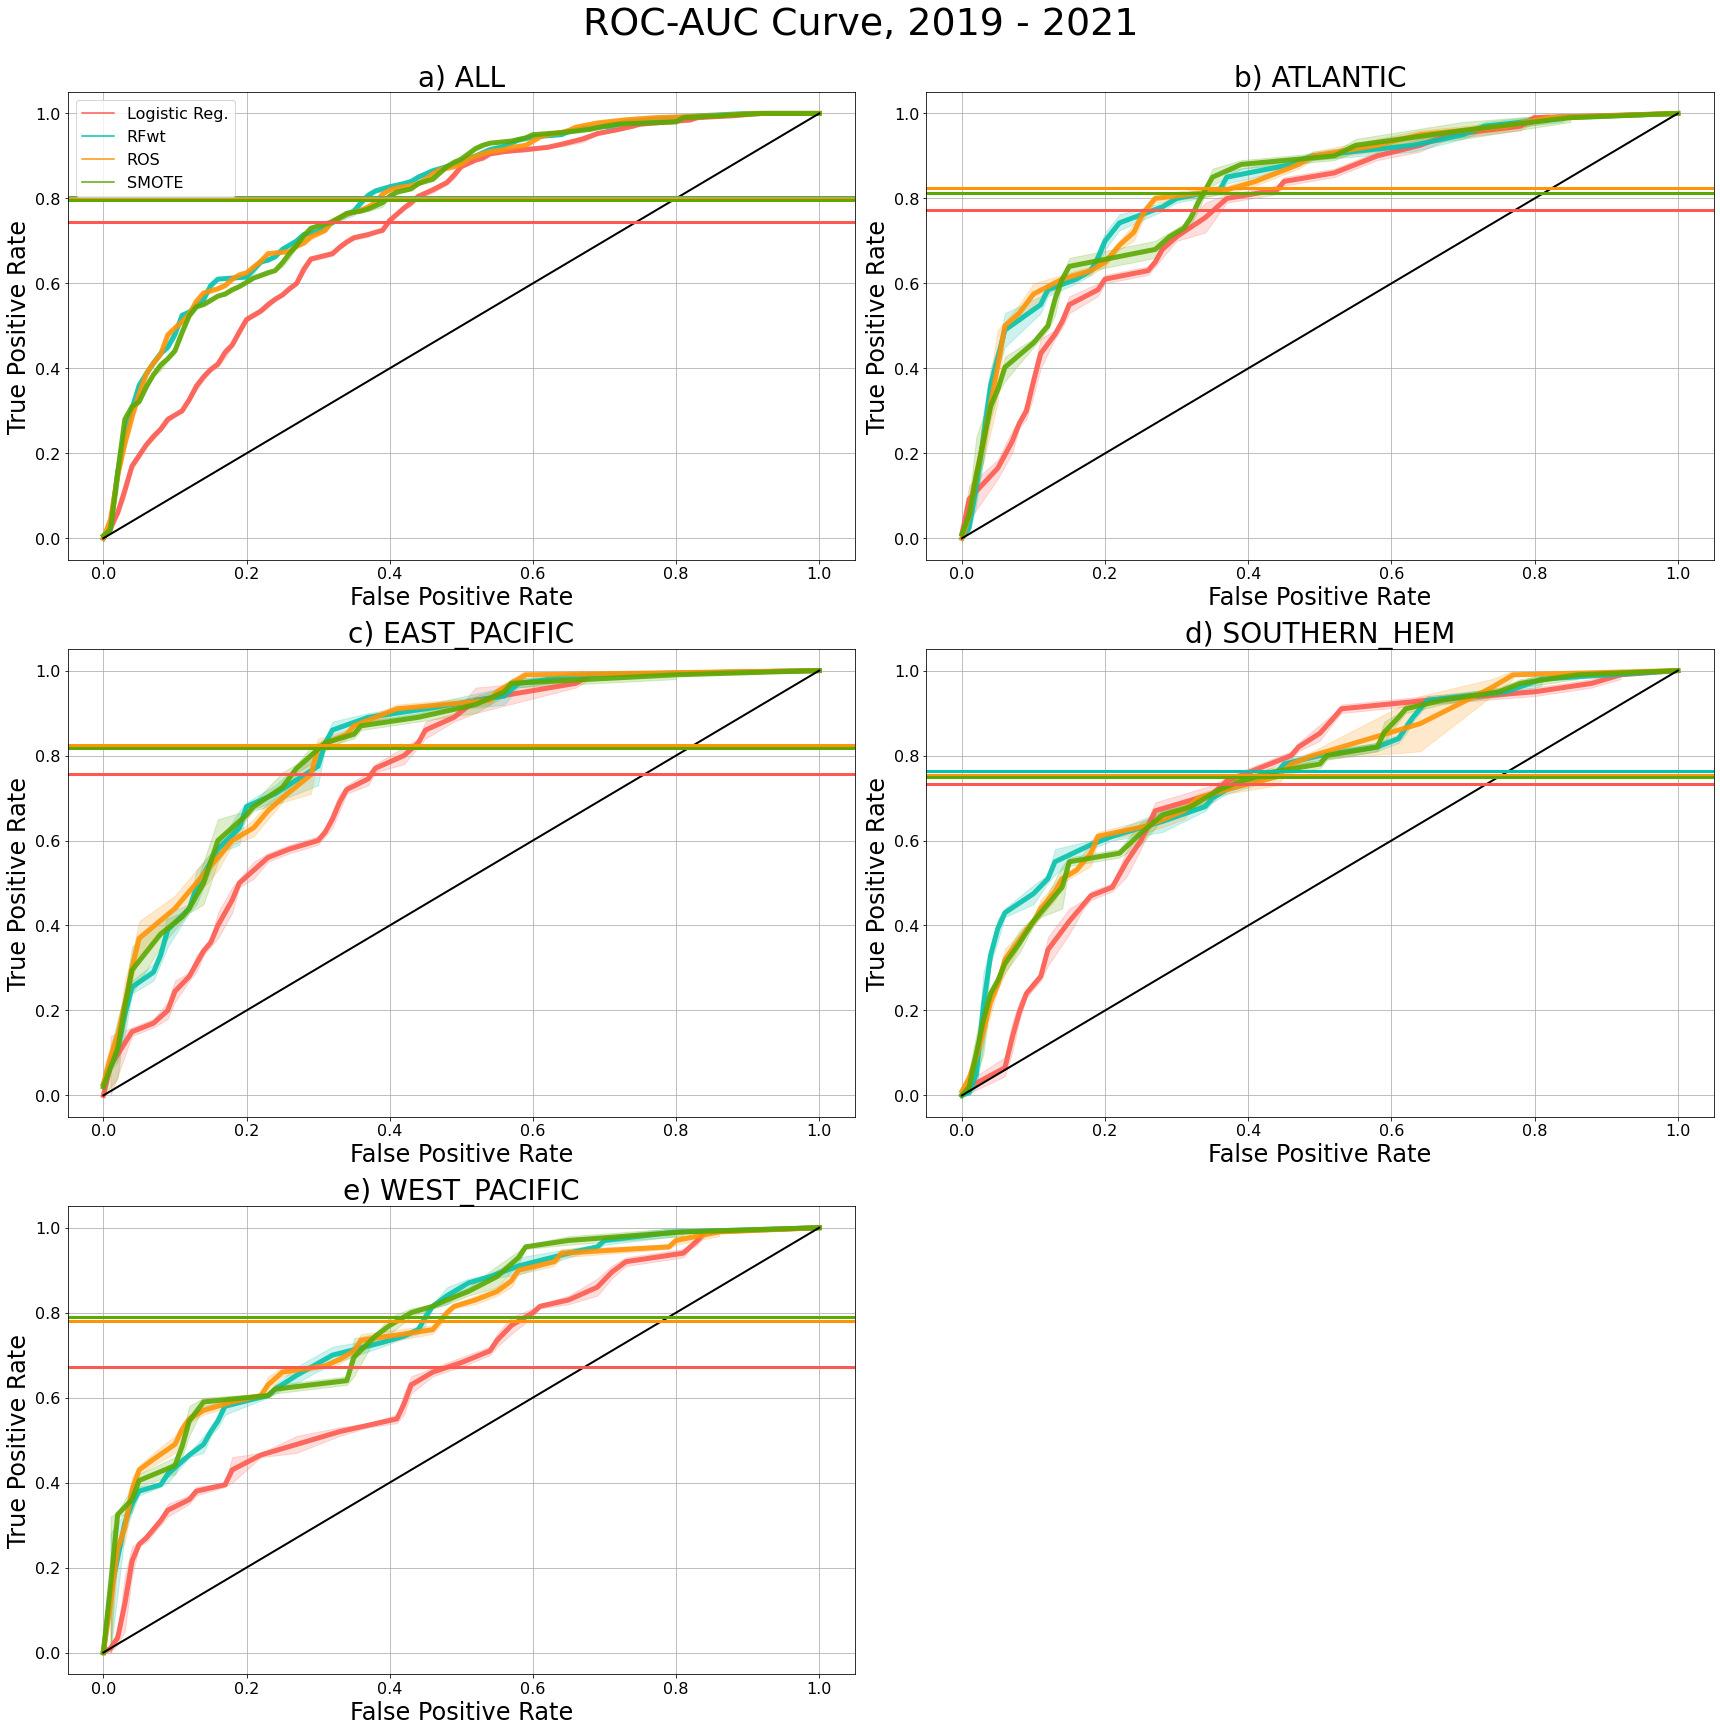

In [22]:
fig17,ax17 = plt.subplots(3,2,figsize=(24,24))
ax_sel = ax17.flatten()
for j in np.arange(0,len(ax_sel)-1):
    iax = ax_sel[j]
   # for isel in np.arange(0,len(basin_ALL)):
#
    ibasin = basin_ALL[j]
    ilett = lett[j]
    #
    roc_vals_plt = roc_auc.set_index(['BASIN']).xs(ibasin).reset_index()
    roc_vals_plt[['FPR round','TPR round']] = roc_vals_plt[['False Positive Rate','True Positive Rate']].round(2)
    # 

    # use_pal = sns.set_palette({'xkcd:turquoise','xkcd:coral','xkcd:tangerine','xkcd:leaf green'})
    sns.lineplot(data=roc_vals_plt.sort_values(by='Model'),x='FPR round',y='TPR round',hue='Model',ax=iax,
                palette=sns.set_palette(pal_2),alpha=0.9,linewidth=5)
    iax.plot([0,1],[0,1],color='k',linewidth=2)
    iax.set_xlabel('False Positive Rate',fontsize=24)
    iax.set_ylabel('True Positive Rate',fontsize=24)
    iax.tick_params(axis='x',labelsize=16)
    iax.tick_params(axis='y',labelsize=16)
    iax.legend(fontsize=16)
    iax.grid()
    #
    if j != 0:
        iax.get_legend().remove()
    #
    for imod in np.arange(0,len(models_ALL)):
        iax.axhline(y=roc_vals_plt.groupby(['Model'])['AUC ROC Score'].max().iloc[imod],color=sns.color_palette()[imod],
                   linewidth=3)
    iax.set_title('{ilett} {ibasin}'.format(ilett=ilett,ibasin=ibasin),fontsize=28)
        #iax.set_title('{ilett} ROC-AUC Curve, {ibasin}, 2019-2021'.format(ilett=ilett,ibasin=ibasin),fontsize=24)
    #
fig17.delaxes(ax_sel[5])
fig17.suptitle('ROC-AUC Curve, 2019 - 2021',fontsize=38,y=1.0001)
fig17.tight_layout()
fig17.savefig(fig_dir_save+'roc_auc_all_panels_TEST.png',format='png',dpi=350,bbox_inches='tight')
fig17.savefig(fig_dir_save+'roc_auc_all_panels_TEST.pdf',format='pdf',bbox_inches='tight')


#### Feature importances

In [23]:
feat_imp = cm_res = pd.read_csv(fpath_load+'Feat_Imp_validation'+path_suff)
feat_imp['Model'] = feat_imp['Model'].replace({'Random Forest (SMOTE)':'SMOTE',
                                          'Random Forest (random oversample)':'ROS',
                                          'Random Forest (class wt)':'RFwt'})

feat_imp = feat_imp.rename(columns={'Unnamed: 0':'Feature'})

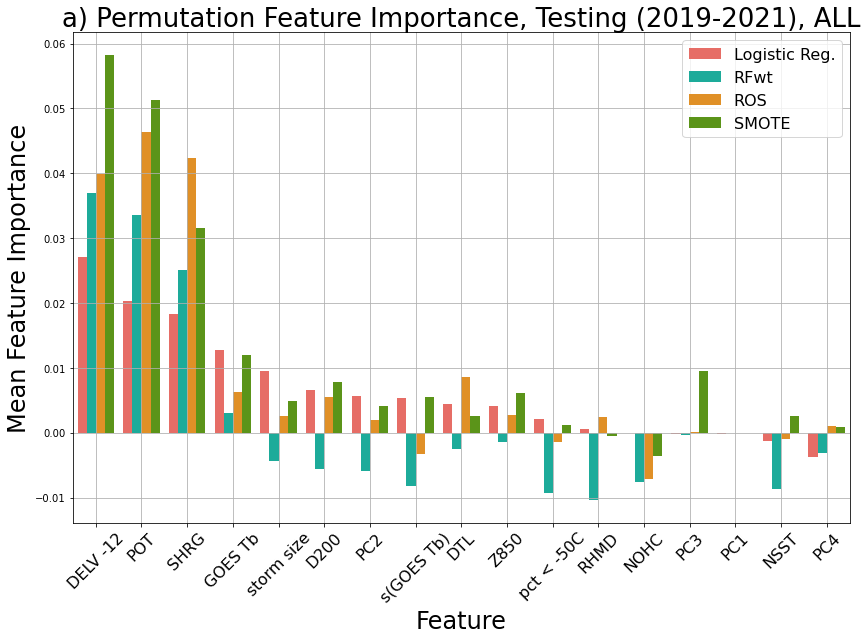

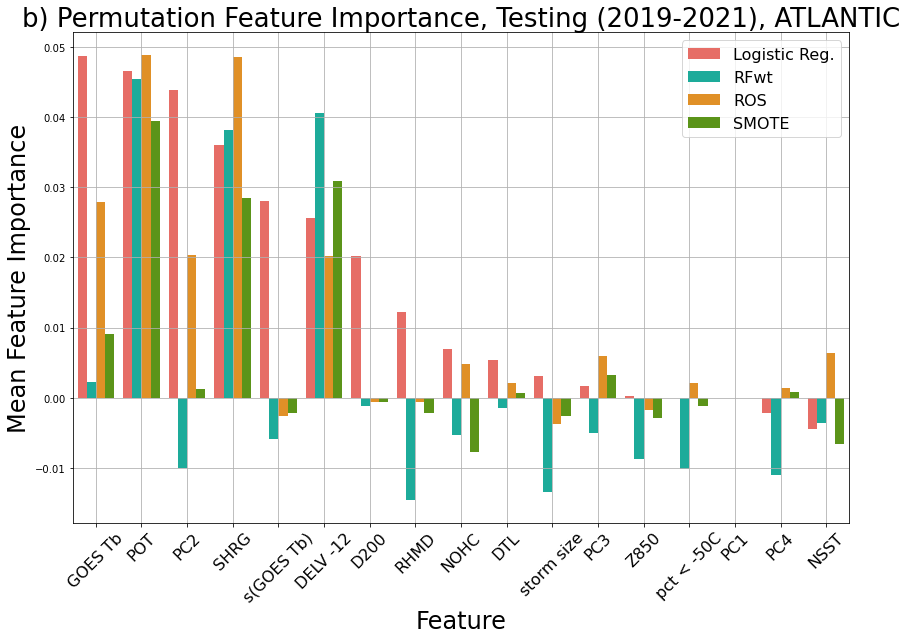

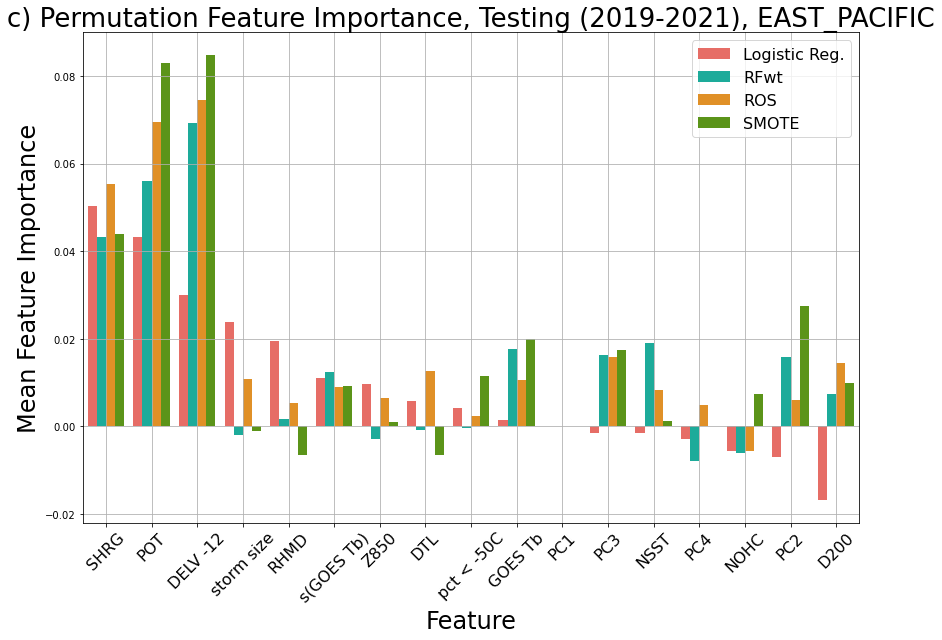

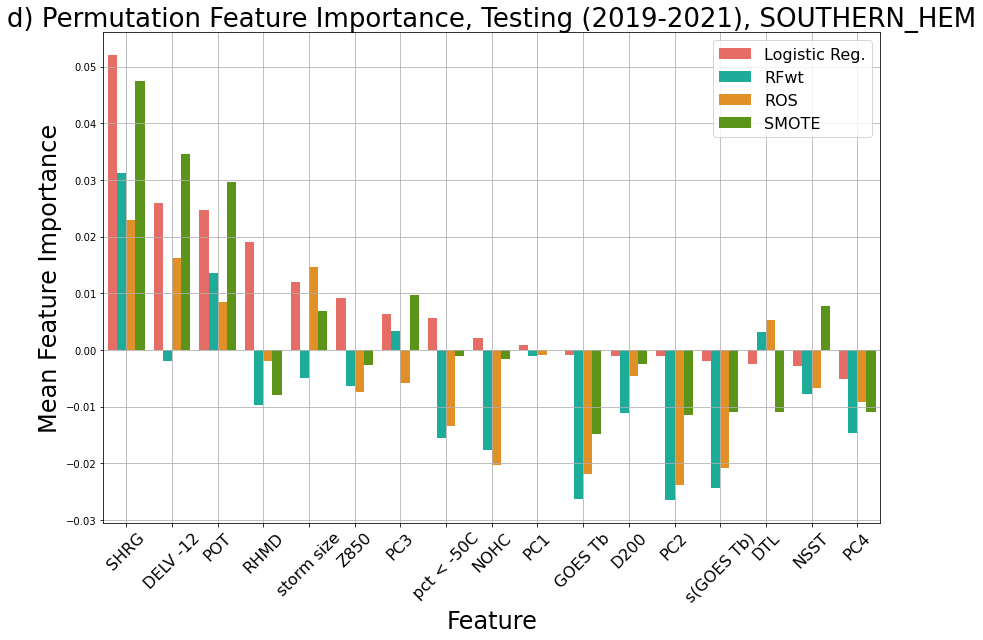

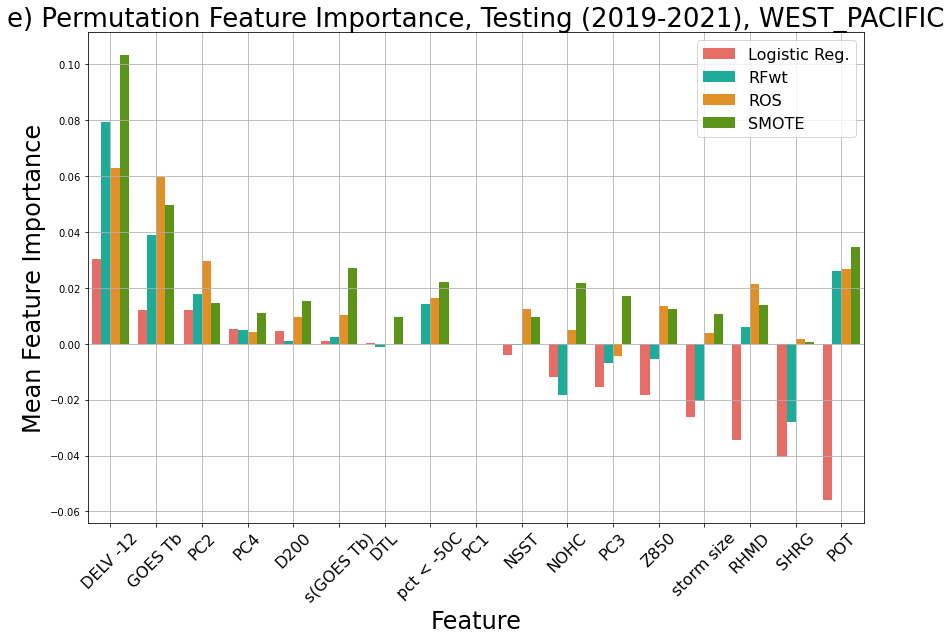

In [24]:
for isel in np.arange(0,len(basin_ALL)):
#
    ibasin = basin_ALL[isel]
    ilett = lett[isel]
    foo = feat_imp.set_index(['BASIN']).xs(ibasin).reset_index().sort_values(by=['Model','mean importance'],
                                                                                     ascending=[True,False])
    fig8,ax8 = plt.subplots(1,1,figsize=(12,9))
    sns.barplot(data=foo,x='Feature',y='mean importance',
                hue='Model',ax=ax8,palette=sns.set_palette(pal_2))
    ax8.tick_params(axis='x',labelsize=16,rotation=45)
    ax8.set_xlabel('Feature',fontsize=24)
    ax8.set_ylabel('Mean Feature Importance',fontsize=24)
    ax8.legend(fontsize=16)
    ax8.grid()
    ax8.set_title('{ilett} Permutation Feature Importance, Testing (2019-2021), {basin}'.format(ilett=ilett,basin=ibasin),
                  fontsize=26)
    #
    fig8.tight_layout()
    fig8.savefig(fig_dir_save+'feat_imp_{basin}_TEST.png'.format(basin=ibasin),format='png',dpi=350,bbox_inches='tight')
    fig8.savefig(fig_dir_save+'feat_imp_{basin}_TEST.pdf'.format(basin=ibasin),format='pdf',bbox_inches='tight')

##### Feature importances, all panels

In [25]:
pal_3 = sns.color_palette(sns.xkcd_palette(['leaf green','tangerine','turquoise','coral']),4)

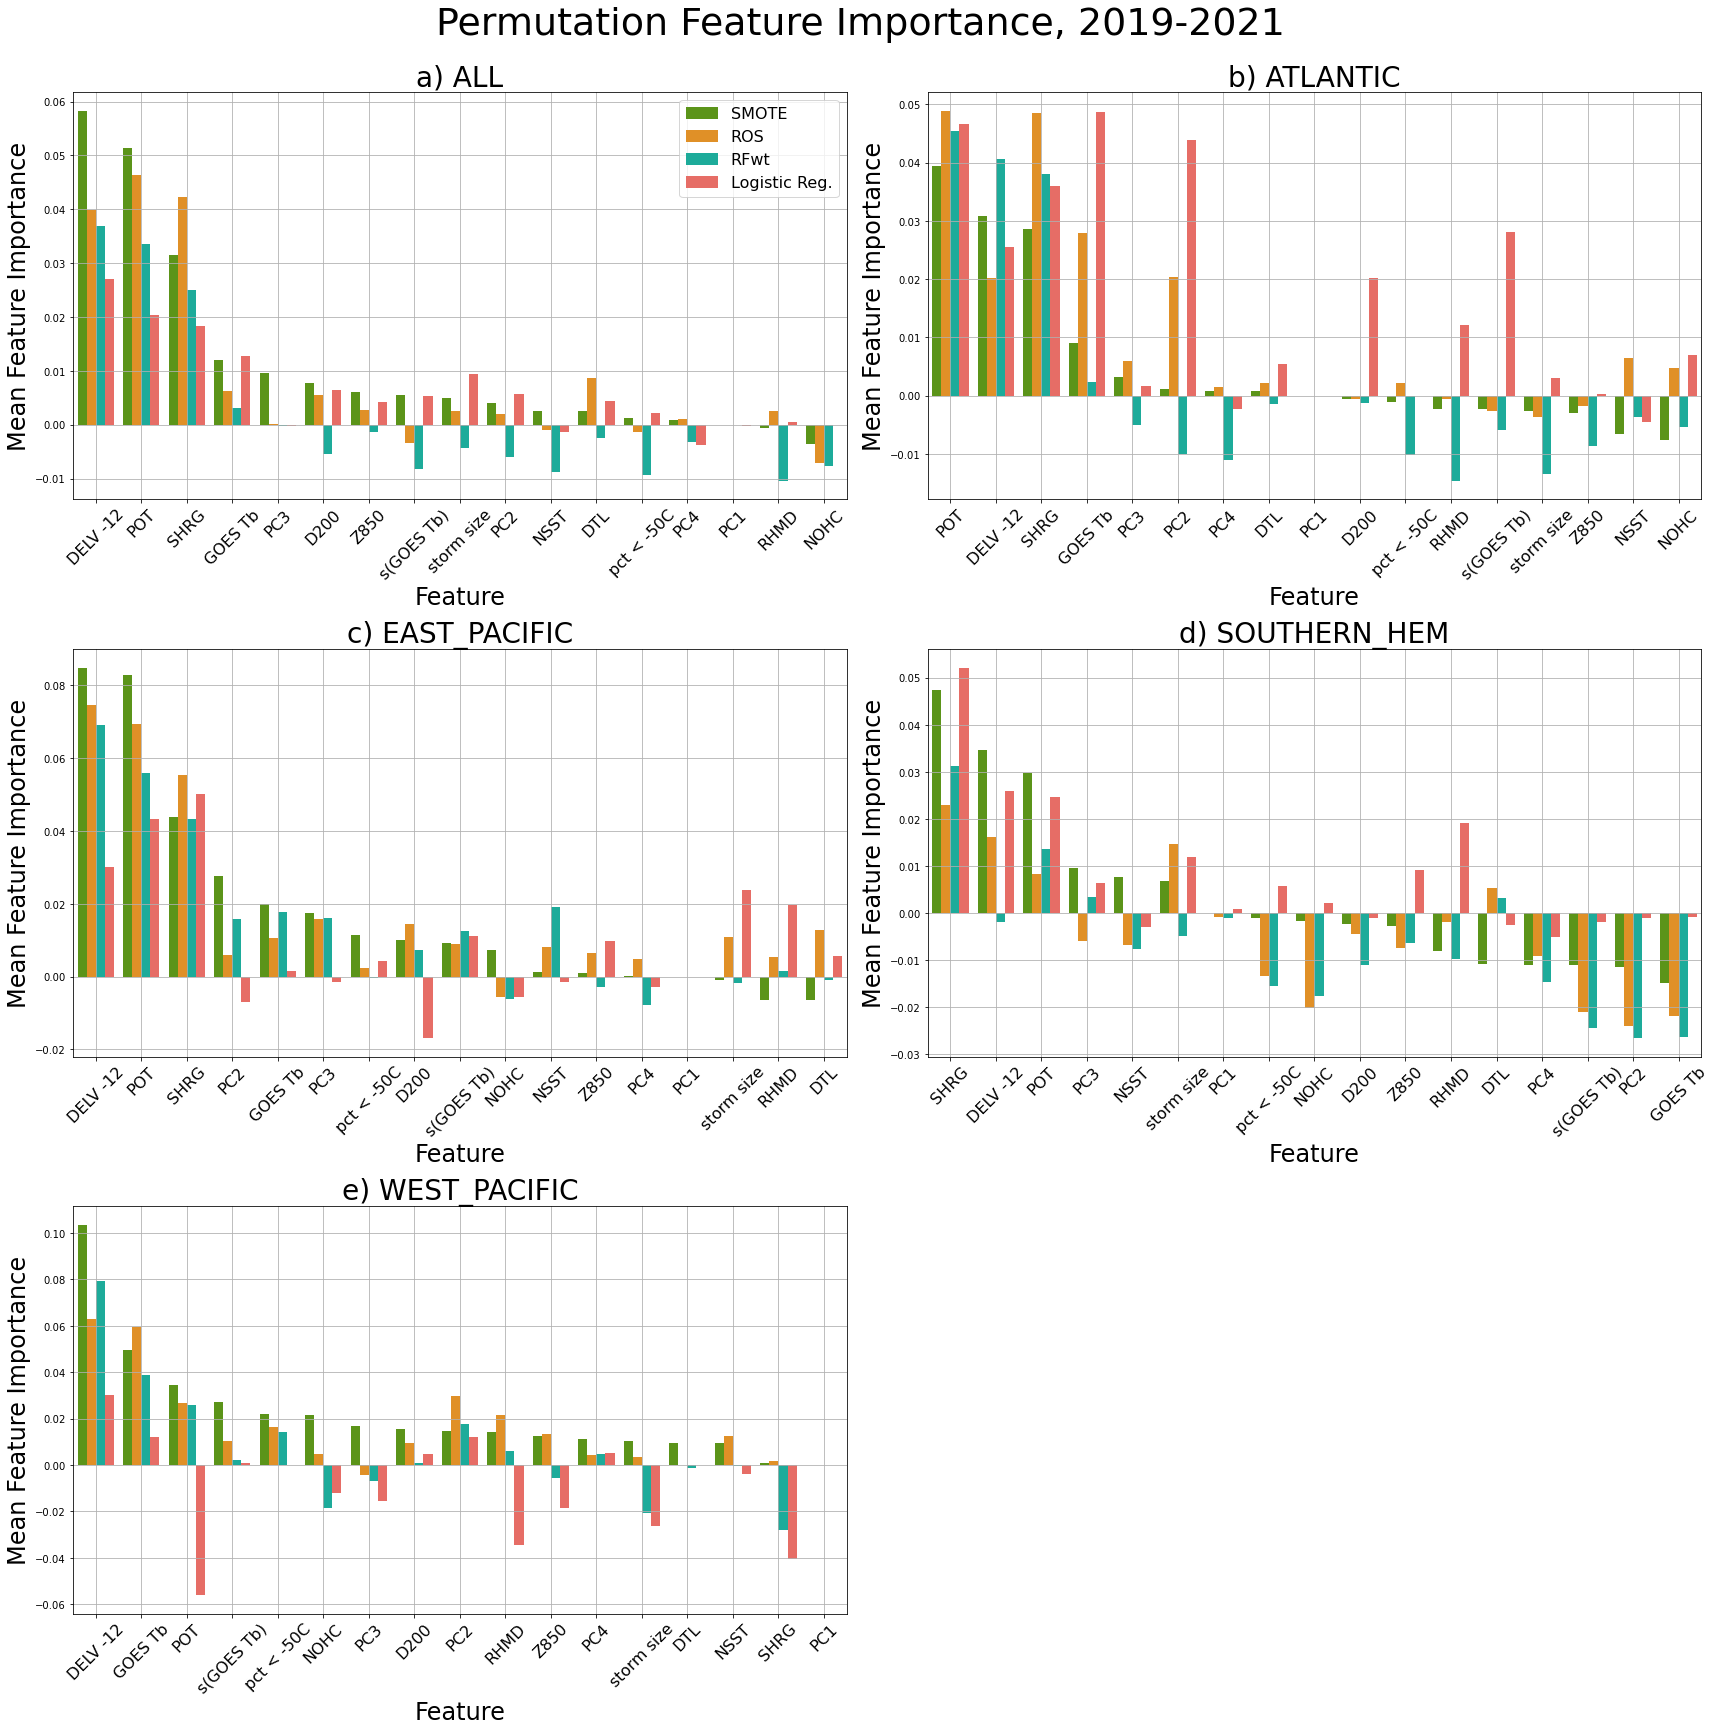

In [26]:
fig18,ax18 = plt.subplots(3,2,figsize=(24,24))
ax_sel = ax18.flatten()
for j in np.arange(0,len(ax_sel)-1):
    iax = ax_sel[j]
   # for isel in np.arange(0,len(basin_ALL)):
#
    ibasin = basin_ALL[j]
    ilett = lett[j]
    #
    fi_sel = feat_imp.set_index(['BASIN']).xs(ibasin).reset_index().sort_values(by=['Model','mean importance'],
                                                                                     ascending=[False,False])
    sns.barplot(data=fi_sel,x='Feature',y='mean importance',
                hue='Model',ax=iax,palette=sns.set_palette(pal_3))
    iax.tick_params(axis='x',labelsize=16,rotation=45)
    iax.set_xlabel('Feature',fontsize=24)
    iax.set_ylabel('Mean Feature Importance',fontsize=24)
    iax.legend(fontsize=16)
    if j > 0:
        iax.get_legend().remove()
    iax.grid()
    iax.set_title('{ilett} {basin}'.format(ilett=ilett,basin=ibasin),fontsize=28)
#
fig18.delaxes(ax_sel[5])
fig18.suptitle('Permutation Feature Importance, 2019-2021',fontsize=38,y=1.0001)
fig18.tight_layout()
fig18.savefig(fig_dir_save+'feat_imp_all_panels_TEST.png',format='png',dpi=350,bbox_inches='tight')
fig18.savefig(fig_dir_save+'feat_imp_all_panels_TEST.pdf',format='pdf',bbox_inches='tight')